In [1]:
import xarray as xr
import numpy  as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.style import use as usestyle
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
from time import perf_counter
import xesmf
import cartopy.crs as ccrs
from cartopy import feature as cfeature
# import metpy as mpy
from pandas import date_range
from glob import glob
from pandas import date_range
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
from matplotlib import ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from astropy.convolution import convolve

In [2]:
# usestyle("paperplots.mplstyle")
from matplotlib import font_manager as fm
fontdir = "/home/ascheb/libfonts/*.ttf"
for fpath in glob(fontdir):
    print(fpath)
    fm.fontManager.addfont(fpath)

usestyle("paperplots.mplstyle")
from matplotlib import rcParams
rcParams["figure.titlesize"] = 20
rcParams["axes.titlesize"] = 16
rcParams["axes.labelsize"] = 16
rcParams["xtick.labelsize"] = 13
rcParams["ytick.labelsize"] = 13
rcParams["axes.linewidth"] = 0.4

/home/ascheb/libfonts/LiberationMono-BoldItalic.ttf
/home/ascheb/libfonts/LiberationSerif-Bold.ttf
/home/ascheb/libfonts/LiberationSans-BoldItalic.ttf
/home/ascheb/libfonts/LiberationSans-Regular.ttf
/home/ascheb/libfonts/LiberationMono-Italic.ttf
/home/ascheb/libfonts/LiberationMono-Bold.ttf
/home/ascheb/libfonts/LiberationMono-Regular.ttf
/home/ascheb/libfonts/LiberationSans-Italic.ttf
/home/ascheb/libfonts/LiberationSerif-BoldItalic.ttf
/home/ascheb/libfonts/LiberationSerif-Italic.ttf
/home/ascheb/libfonts/LiberationSans-Bold.ttf
/home/ascheb/libfonts/LiberationSerif-Regular.ttf


In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
def add_cartofeatures_fulldomain(geoax):
    geoax.set_extent((controlgrid["x"].min(), controlgrid["x"].max(), controlgrid["y"].min(), controlgrid["y"].max()), crs = ramscrs)
    # ax.annotate(axlabels[i], (0.04, 0.94), xycoords = "axes fraction", color = "black", fontsize = 6.5, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="dodgerblue", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-83, -79, -75])
    gl.ylocator = mticker.FixedLocator([38, 40, 42, 44, 46])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    # ax.set_ylabel("Latitude")
    # ax.set_xlabel("Longitude")
    return geoax

In [5]:
def add_cartofeatures_zoomdomain(geoax):
    geoax.set_extent((controlgrid["x"][50], controlgrid["x"][650], controlgrid["y"][450], controlgrid["y"][1050]), crs = ramscrs)
    # ax.annotate(axlabels[i], (0.04, 0.94), xycoords = "axes fraction", color = "black", fontsize = 6.5, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="dodgerblue", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-84, -82, -80, -78])
    gl.ylocator = mticker.FixedLocator([42, 43, 44, 45, 46])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    # ax.set_ylabel("Latitude")
    # ax.set_xlabel("Longitude")
    return geoax

In [6]:
def add_cartofeatures_wmovement(geoax):
    geoax.set_extent((-84, -80, 41, 44), crs = ccrs.PlateCarree())
    # ax.annotate(axlabels[i], (0.04, 0.94), xycoords = "axes fraction", color = "black", fontsize = 6.5, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="dodgerblue", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-83, -82, -81])
    gl.ylocator = mticker.FixedLocator([42, 43])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    # ax.set_ylabel("Latitude")
    # ax.set_xlabel("Longitude")
    return geoax

In [7]:
def add_cartofeatures_brownlake(geoax):
    geoax.set_extent((-80.75, -78.75, 42, 44.5), crs = ccrs.PlateCarree())
    # ax.annotate(axlabels[i], (0.04, 0.94), xycoords = "axes fraction", color = "black", fontsize = 6.5, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="dodgerblue", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-81, -80, -79])
    gl.ylocator = mticker.FixedLocator([43, 44])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    # ax.set_ylabel("Latitude")
    # ax.set_xlabel("Longitude")
    return geoax

In [8]:
def add_cartofeatures_snowbox(geoax):
    geoax.set_extent((controlgrid["x"][200], controlgrid["x"][750], controlgrid["y"][150], controlgrid["y"][650]), crs = ramscrs)
    # ax.annotate(axlabels[i], (0.04, 0.94), xycoords = "axes fraction", color = "black", fontsize = 6.5, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="dodgerblue", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-82, -81, -80, -79, -78])
    gl.ylocator = mticker.FixedLocator([38, 39, 40, 41, 42])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    # ax.set_ylabel("Latitude")
    # ax.set_xlabel("Longitude")
    return ax

In [9]:
controlgrid = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/gridconsts.nc")
nlhgrid = xr.open_dataset("/moonbow/ascheb/les/2010/hires_nolake/gridconsts.nc")

In [10]:
lhymin = 640; lhymax = 1040; lhxmin = 140; lhxmax = 420 #lh - main body of Lake Huron
gbymin = 800; gbymax = 1000; gbxmin = 420; gbxmax = 700 #gb - Georgian Bay and downwind land
gbpatchpoints = np.zeros((4, 2))
gbpatchpoints[:,0] = [controlgrid["x"].values[gbxmin], controlgrid["x"].values[gbxmax], controlgrid["x"].values[gbxmax], controlgrid["x"].values[gbxmin]]
gbpatchpoints[:,1] = [controlgrid["y"].values[gbymin], controlgrid["y"].values[gbymin], controlgrid["y"].values[gbymax], controlgrid["y"].values[gbymax]]

In [11]:
lhpatchpoints = np.zeros((4, 2))
lhpatchpoints[:,0] = [controlgrid["x"].values[lhxmin], controlgrid["x"].values[lhxmax], controlgrid["x"].values[lhxmax], controlgrid["x"].values[lhxmin]]
lhpatchpoints[:,1] = [controlgrid["y"].values[lhymin], controlgrid["y"].values[lhymin], controlgrid["y"].values[lhymax], controlgrid["y"].values[lhymax]]

## Make a figure of the simulation domains (terrain height and water body location)

In [15]:
# terls = colors.LightSource(azdeg = 315, altdeg = 30)
# statesgeom = shapely.read_file("cb_2018_us_state_20m/cb_2018_us_state_20m.shp")
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 3.5), sharex = True, sharey = True, dpi = 300, subplot_kw = {"projection": ramscrs})
axlabels = ["(a)", "(b)"]
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
for i, ax in enumerate(fig.get_axes()):
    # ax.set_extent((controlgrid["lon2d"].min(), controlgrid["lon2d"].max(), controlgrid["lat2d"].min()-2, controlgrid["lat2d"].max()), crs = ccrs.PlateCarree())
    ax = add_cartofeatures_fulldomain(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
termp = ax1.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, transform = ramscrs, zorder = 0)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], nlhgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, transform = ramscrs)
ax1.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Patch"][0,:,:].where(controlgrid["Patch"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "coolwarm_r", shading = "nearest", transform = ramscrs)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], nlhgrid["Patch"][0,:,:].where(nlhgrid["Patch"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "coolwarm_r", shading = "nearest", transform = ramscrs)
ax2.plot([controlgrid["x"][lhxmin], controlgrid["x"][lhxmax]], [controlgrid["y"][lhymin], controlgrid["y"][lhymin]], color = "red", transform = ramscrs)
ax1.annotate("Lake Huron", [-82.7, 44.6], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 290, color = "white", transform = ccrs.PlateCarree())
ax1.annotate("Lake Erie", [-81.2, 42.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 23, color = "white", transform = ccrs.PlateCarree())
ax1.annotate("Lake Ont.", [-78, 43.6], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 0, color = "white", transform = ccrs.PlateCarree())
ax1.annotate("GB", [-80.7, 45.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 0, color = "white", transform = ccrs.PlateCarree())
ax2.add_patch(mpl.patches.Polygon(gbpatchpoints, edgecolor = "firebrick", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
ax2.add_patch(mpl.patches.Polygon(lhpatchpoints, edgecolor = "firebrick", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
ax2.annotate("Box \n LH", [-82.5, 44.8], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "red", transform = ccrs.PlateCarree())
ax2.annotate("Box \n GB", [-79.3, 45.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "red", transform = ccrs.PlateCarree())
# ax2.annotate("3", [-79, 40], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree())
ax2.annotate("2", [-79.5, 42], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree())
ax2.annotate("1", [-80.5, 43.5], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree())

ax1.set_title("CONTROL", fontfamily = "Arial")
ax2.set_title("NLH", fontfamily = "Arial")
# ax1.set_ylabel("Latitude (Degrees N)", fontfamily = "arial")
cbar = fig.colorbar(termp, ax = [ax1, ax2], orientation = "horizontal", ticks = [0, 250, 500, 750, 1000], fraction = 0.05, extend = "max"); cbar.set_label("Terrain Height (m)", fontfamily = "Arial")

# ax1.set_xlabel("Longitude (Degrees E)", fontsize = 20, fontfamily = "arial")
# ax2.set_xlabel("Longitude (Degrees E)", fontsize = 20, fontfamily = "arial")
# # fig.text(0.5, 0.18, "Longitude (Degrees E)", fontsize = 20, ha = "center", name = "Liberation Serif")
# fig.suptitle("Simulation Domain", fontfamily = "Arial")
fig.savefig("../PaperFigs/domaincarto.png")
plt.close()
del fig; del ax1; del ax2

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


### Do the same thing, but now with hillshading

In [17]:
from matplotlib.colors import LightSource
hillshadegreycmap = mpl.colormaps.get_cmap("Greys")(np.linspace(0, 1, 256))
hillshadegreycmap[:,3] = abs(np.linspace(-0.5, 0.5, 256))
hillshadegreycmap = mpl.colors.ListedColormap(hillshadegreycmap)
print(hillshadegreycmap)
ls = LightSource (azdeg = 45, altdeg = 20)
topomp = ls.hillshade(controlgrid["Topo"].values, dx = 1000, dy = 1000, vert_exag = 50)

# terls = colors.LightSource(azdeg = 315, altdeg = 30)
# statesgeom = shapely.read_file("cb_2018_us_state_20m/cb_2018_us_state_20m.shp")
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 3.5), sharex = True, sharey = True, dpi = 300, subplot_kw = {"projection": ramscrs})
axlabels = ["(a)", "(b)"]
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
for i, ax in enumerate(fig.get_axes()):
    # ax.set_extent((controlgrid["lon2d"].min(), controlgrid["lon2d"].max(), controlgrid["lat2d"].min()-2, controlgrid["lat2d"].max()), crs = ccrs.PlateCarree())
    ax = add_cartofeatures_fulldomain(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
termp = ax1.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, transform = ramscrs, zorder = 0)
ax1.pcolormesh(controlgrid["x"], controlgrid["y"], topomp, cmap = hillshadegreycmap, vmin = 0, vmax = 1, transform = ramscrs, zorder = 2)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], nlhgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, transform = ramscrs)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], topomp, cmap = hillshadegreycmap, vmin = 0, vmax = 1, transform = ramscrs, zorder = 2)
ax1.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Patch"][0,:,:].where(controlgrid["Patch"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "coolwarm_r", shading = "nearest", transform = ramscrs, zorder = 1)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], nlhgrid["Patch"][0,:,:].where(nlhgrid["Patch"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "coolwarm_r", shading = "nearest", transform = ramscrs, zorder = 1)
# ax2.plot([controlgrid["x"][lhxmin], controlgrid["x"][lhxmax]], [controlgrid["y"][lhymin], controlgrid["y"][lhymin]], color = "red", transform = ramscrs)
ax1.annotate("Lake Huron", [-82.7, 44.6], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 290, color = "white", transform = ccrs.PlateCarree(), zorder = 3)
ax1.annotate("Lake Erie", [-81.2, 42.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 23, color = "white", transform = ccrs.PlateCarree(), zorder = 3)
ax1.annotate("Lake Ont.", [-78, 43.6], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 0, color = "white", transform = ccrs.PlateCarree(), zorder = 3)
ax1.annotate("GB", [-80.7, 45.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 0, color = "white", transform = ccrs.PlateCarree(), zorder = 3)
ax2.add_patch(mpl.patches.Polygon(gbpatchpoints, edgecolor = "firebrick", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
ax2.add_patch(mpl.patches.Polygon(lhpatchpoints, edgecolor = "firebrick", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
ax2.annotate("Box \n LH", [-82.5, 44.8], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "red", transform = ccrs.PlateCarree(), zorder = 4)
ax2.annotate("Box \n GB", [-79.3, 45.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "red", transform = ccrs.PlateCarree(), zorder = 4)
# ax2.annotate("3", [-79, 40], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree())
ax2.annotate("2", [-79.5, 42], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree(), zorder = 3)
ax2.annotate("1", [-80.5, 43.5], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree(), zorder = 3)

ax1.set_title("CONTROL", fontfamily = "Arial")
ax2.set_title("NLH", fontfamily = "Arial")
# ax1.set_ylabel("Latitude (Degrees N)", fontfamily = "arial")
cbar = fig.colorbar(termp, ax = [ax1, ax2], orientation = "horizontal", ticks = [0, 250, 500, 750, 1000], fraction = 0.05, extend = "max"); cbar.set_label("Terrain Height (m)", fontfamily = "Arial")

# ax1.set_xlabel("Longitude (Degrees E)", fontsize = 20, fontfamily = "arial")
# ax2.set_xlabel("Longitude (Degrees E)", fontsize = 20, fontfamily = "arial")
# # fig.text(0.5, 0.18, "Longitude (Degrees E)", fontsize = 20, ha = "center", name = "Liberation Serif")
# fig.suptitle("Simulation Domain", fontfamily = "Arial")
fig.savefig("../PaperFigs/domaincarto-hillshade.png")
plt.close()
del fig; del ax1; del ax2

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


## Calculating/Plotting Changes in Snowfall

In [18]:
nolake_snow_old = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_nolake/oldprocessdata/mergedvars_2010-01-02-060000.nc")
control_snow_old = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_control/oldprocessdata/mergedvars_2010-01-02-060000.nc")
nolake_snow_new = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_nolake/oldprocessdata/mergedvars_2010-01-03-060000.nc")
control_snow_new = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_control/oldprocessdata/mergedvars_2010-01-03-060000.nc")

snowdiff_control = control_snow_new["SnowPrecipTotal"]+control_snow_new["AggPrecipTotal"]-control_snow_old["SnowPrecipTotal"]-control_snow_old["AggPrecipTotal"]
snowdiff_nolake = nolake_snow_new["SnowPrecipTotal"]+nolake_snow_new["AggPrecipTotal"]-nolake_snow_old["SnowPrecipTotal"]-nolake_snow_old["AggPrecipTotal"]

### Define boxes for evaluating snowfall in Regions A,B,C,D,E

In [19]:
ix0 = 400; iy0 = 525 #Northwest side of the "downwind of lake erie" box, at the center of the downwind shore
x0 = snowdiff_control["x"].isel(x = ix0); y0 = snowdiff_control["y"].isel(y = iy0); dxy = np.diff(snowdiff_control["x"])[0]
width = 400000; length = 305000 #m, dimensions of the box
tarray = np.arange(0, length+1, dxy); narray = np.arange(-width/2, width/2+1, dxy) #Coordinates of the box in tangent (long-axis) and normal (short-axis) directions. Normal is negative and positive (northeast and southwest), while tangent is only positive (to the right)
tmesh, nmesh = np.meshgrid(tarray, narray)
print(tmesh)
print(nmesh)
angle = np.pi/180*(-60) #Angle of the long axis of the box, with respect to the horizontal
xbox = x0.values+np.cos(angle)*tmesh-np.sin(angle)*nmesh
ybox = y0.values+np.sin(angle)*tmesh+np.cos(angle)*nmesh
snowbox = xr.DataArray(coords = {"y": (("normal", "tangent"), ybox), "x": (("normal", "tangent"), xbox), "normal": narray, "tangent": tarray}, dims = ["normal", "tangent"])

downwindsnow_control = snowdiff_control.interp(x = snowbox["x"], y = snowbox["y"])
downwindsnow_nolake = snowdiff_nolake.interp(x = snowbox["x"], y = snowbox["y"])

print(downwindsnow_nolake.mean())
print(downwindsnow_control.mean())


patchpoints = np.zeros((4, 2))
patchpoints[:,0] = [downwindsnow_control["x"].values[0,0], downwindsnow_control["x"].values[0, -1], downwindsnow_control["x"].values[-1, -1], downwindsnow_control["x"].values[-1, 0]]
patchpoints[:,1] = [downwindsnow_control["y"].values[0,0], downwindsnow_control["y"].values[0, -1], downwindsnow_control["y"].values[-1, -1], downwindsnow_control["y"].values[-1, 0]]

print(downwindsnow_control[210:250, 0:100].mean(), downwindsnow_nolake[210:250, 0:100].mean(), downwindsnow_control[210:250, 0:100].sum()/downwindsnow_nolake[210:250, 0:100].sum()) #Change in snowfall in main band
#Points 210:250, 0:100 form a rectangle roughly bounding the main snow band over Lake Erie in the CONTROL simulation
patchpointssub = np.zeros((4, 2)) #These are the points for box B in the figure below, outlining the main band
patchpointssub[:,0] = [downwindsnow_control["x"].values[210,0], downwindsnow_control["x"].values[210, 100], downwindsnow_control["x"].values[250, 100], downwindsnow_control["x"].values[250, 0]]
patchpointssub[:,1] = [downwindsnow_control["y"].values[210,0], downwindsnow_control["y"].values[210, 100], downwindsnow_control["y"].values[250, 100], downwindsnow_control["y"].values[250, 0]]
# print(downwindsnow_control[210:250, 0:100].mean(), downwindsnow_nolake[210:250, 0:100].mean(), downwindsnow_control[210:250, 0:100].sum()/downwindsnow_nolake[210:250, 0:100].sum())

print(downwindsnow_control[350:400, 0:100].mean(), downwindsnow_nolake[350:400, 0:100].mean(), downwindsnow_control[350:400, 0:100].sum()/downwindsnow_nolake[350:400, 0:100].sum()) #Change in snowfall in ne Lake Erie (Region D)
#Points 350:4000, 0:100 form a rectangle roughly bounding the region of snowfall from the "brown lake" effect in NE Lake Erie
patchpointsne = np.zeros((4,2)) #Points bounding the band in northeast Lake Erie (box D)
patchpointsne[:,0] = [downwindsnow_control["x"].values[350,0], downwindsnow_control["x"].values[350, 100], downwindsnow_control["x"].values[400, 100], downwindsnow_control["x"].values[400, 0]]
patchpointsne[:,1] = [downwindsnow_control["y"].values[350,0], downwindsnow_control["y"].values[350, 100], downwindsnow_control["y"].values[400, 100], downwindsnow_control["y"].values[400, 0]]
# print(downwindsnow_control[350:400, 0:100].mean(), downwindsnow_nolake[350:400, 0:100].mean(), downwindsnow_control[350:400, 0:100].sum()/downwindsnow_nolake[350:450, 0:100].sum())

patchpoints_between = np.zeros((4, 2)) #Points bounding area downwind of Lake Erie between box B and box D (box C)
patchpoints_between[:,0] = [downwindsnow_control["x"].values[250,0], downwindsnow_control["x"].values[250, 100], downwindsnow_control["x"].values[350, 100], downwindsnow_control["x"].values[350, 0]]
patchpoints_between[:,1] = [downwindsnow_control["y"].values[250,0], downwindsnow_control["y"].values[250, 100], downwindsnow_control["y"].values[350, 100], downwindsnow_control["y"].values[350, 0]]
# print(downwindsnow_control[250:350, 0:100].mean(), downwindsnow_nolake[250:350, 0:100].mean(), downwindsnow_control[250:350, 0:100].sum()/downwindsnow_nolake[250:350, 0:100].sum())

[[     0.   1000.   2000. ... 303000. 304000. 305000.]
 [     0.   1000.   2000. ... 303000. 304000. 305000.]
 [     0.   1000.   2000. ... 303000. 304000. 305000.]
 ...
 [     0.   1000.   2000. ... 303000. 304000. 305000.]
 [     0.   1000.   2000. ... 303000. 304000. 305000.]
 [     0.   1000.   2000. ... 303000. 304000. 305000.]]
[[-200000. -200000. -200000. ... -200000. -200000. -200000.]
 [-199000. -199000. -199000. ... -199000. -199000. -199000.]
 [-198000. -198000. -198000. ... -198000. -198000. -198000.]
 ...
 [ 198000.  198000.  198000. ...  198000.  198000.  198000.]
 [ 199000.  199000.  199000. ...  199000.  199000.  199000.]
 [ 200000.  200000.  200000. ...  200000.  200000.  200000.]]
<xarray.DataArray ()>
array(1.57374747)
<xarray.DataArray ()>
array(1.87139324)
<xarray.DataArray ()>
array(8.70520571) <xarray.DataArray ()>
array(2.38316553) <xarray.DataArray ()>
array(3.65279105)
<xarray.DataArray ()>
array(5.58332851) <xarray.DataArray ()>
array(5.19706596) <xarray.Data

### Plot Snowfall Comparison

In [22]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize = (7.8, 6), dpi = 200, layout = "compressed", subplot_kw = {"projection": ramscrs})
startt = datetime(2010, 1, 2, 6, 0, 0); print(startt)
endt = datetime(2010, 1, 3, 6, 0, 0); print(endt)
axlabelstop = ["(a)", "(b)", "(c)"]
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
for i, ax in enumerate((ax11, ax12, ax13)):
    ax = add_cartofeatures_fulldomain(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabelstop[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    termp = ax.pcolormesh(control_snow_old["x"], control_snow_old["y"], control_snow_old["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)
ax13.add_patch(mpl.patches.Polygon(patchpoints, edgecolor = "black", facecolor = [1, 0, 0, 0], linewidth = 0.6, zorder = 3, transform = ramscrs))
ax13.add_patch(mpl.patches.Polygon(patchpointssub, edgecolor = "black", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
ax13.add_patch(mpl.patches.Polygon(patchpointsne, edgecolor = "black", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
ax13.add_patch(mpl.patches.Polygon(patchpoints_between, edgecolor = "black", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
axlabelsbot = ["(d)", "(e)", "(f)"]
for i, ax in enumerate((ax21, ax22, ax23)):
    ax = add_cartofeatures_snowbox(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabelsbot[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    ax.add_patch(mpl.patches.Polygon(patchpoints, edgecolor = "black", facecolor = [1, 0, 0, 0], linewidth = 0.6, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpointssub, edgecolor = "black", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpointsne, edgecolor = "black", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpoints_between, edgecolor = "black", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
    ax.annotate("A", [-81, 39], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    # if ax in (ax22, ax23):
    ax.annotate("B", [-80.4, 41.3], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("C", [-79.7, 41.6], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("D", [-78.9, 41.95], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    # ax.annotate("E", [-79, 39.9], horizontalalignment = "center", verticalalignment = "center", fontsize = 8, color = "black", transform = ccrs.PlateCarree())
    termp = ax.pcolormesh(control_snow_old["x"], control_snow_old["y"], control_snow_old["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)

#Because of the heavy snow in Region B in CONTROL (leading to dark red in ax21), we need to plot in white there instead of black
# ax21.annotate("B", [-80.4, 41.3], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "white", transform = ccrs.PlateCarree())

    # ax.pcolormesh(afile_control["lon1d"], afile_control["lat1d"], afile_control["Patch"][0,:,:].where(afile_control["Patch"][0,:,:]==1), color = "Navy", zorder = 0)
ax11.set_title("CONTROL")
ax12.set_title("NLH")
ax13.set_title("CONTROL-NLH")
# fig.suptitle(f"24-Hour Snowfall Ending {(endt).strftime('%d')} Jan - {(endt).strftime('%H%M')} UTC", y = 0.96)
from palettable.lightbartlein.diverging import BrownBlue10_10
snwdiffcmap = BrownBlue10_10.get_mpl_colormap()
ax11.pcolormesh(control_snow_old["x"], control_snow_old["y"], control_snow_old["Patch"][0,:,:].where(control_snow_old["Patch"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax12.pcolormesh(control_snow_old["x"], control_snow_old["y"], nolake_snow_old["Patch"][0,:,:].where(nolake_snow_old["Patch"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
snowmp = ax11.pcolormesh(control_snow_old["x"], control_snow_old["y"], snowdiff_control.where(snowdiff_control>0.1), shading = "nearest", cmap = "twilight", vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
ax12.pcolormesh(control_snow_old["x"], control_snow_old["y"], snowdiff_nolake.where(snowdiff_nolake>0.1), shading = "nearest", cmap = "twilight", vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
diffmp = ax13.pcolormesh(control_snow_old["x"], control_snow_old["y"], snowdiff_control-snowdiff_nolake, shading = "nearest", cmap = snwdiffcmap, vmin = -15, vmax = 15, zorder = 2, transform = ramscrs)
# # # ax1.contour(afile_control["lon1d"], afile_control["lat1d"], afile_control["Patch"][1,:,:], levels = [0.999], colors = "white", linestyles = "-", linewidths = 0.7)
# # # ax1.legend(loc = "lower left", fontsize = 20, handles = [fakecontour])
# # # ax2.contour(afile_control["lon1d"], afile_control["lat1d"], afile_nolake["Patch"][1,:,:], levels = [0.999], colors = "white", linestyles = "-", linewidths = 0.7)
# # # ax2.legend(loc = "lower left", fontsize = 20, handles = [fakecontour])

ax21.set_title("CONTROL")
ax22.set_title("NLH")
ax23.set_title("CONTROL-NLH")
ax21.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], control_snow_old["Patch"][0,150:650,200:750].where(control_snow_old["Patch"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax22.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], nolake_snow_old["Patch"][0,150:650,200:750].where(nolake_snow_old["Patch"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax21.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], snowdiff_control[150:650,200:750].where(snowdiff_control[150:650,200:750]>0.1), shading = "nearest", cmap = "twilight", vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
ax22.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], snowdiff_nolake[150:650,200:750].where(snowdiff_nolake[150:650,200:750]>0.1), shading = "nearest", cmap = "twilight", vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
ax23.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], snowdiff_control[150:650,200:750]-snowdiff_nolake[150:650,200:750], shading = "nearest", cmap = snwdiffcmap, vmin = -15, vmax = 15, zorder = 2, transform = ramscrs)
fig.get_layout_engine().set(w_pad = 6/72, h_pad = 3/72, wspace = 0.05, hspace = 0)

snowcbar = fig.colorbar(snowmp, ax = [ax11,ax21], orientation = "horizontal", fraction = 0.05, extend = "max", pad = 0.05); snowcbar.set_label("Total Snowfall (mm Liq. Eq.)", fontsize = 12)
tercbar = fig.colorbar(termp, ax = [ax12,ax22], orientation = "horizontal", fraction = 0.05, extend = "max", pad = 0.05); tercbar.set_label("Terrain Height (m)", fontsize = 12)
snwdiffcbar = fig.colorbar(diffmp, ax = [ax13,ax23], orientation = "horizontal", fraction = 0.05, extend = "both", pad = 0.05); snwdiffcbar.set_label("Diff. in Total Snowfall", fontsize = 12);
for cbari in [snowcbar, tercbar, snwdiffcbar]:
    cbari.ax.tick_params(labelsize = 10)
# # ax1.scatter(
fig.savefig(f"../PaperFigs/SnowTotCompcarto_{endt.strftime('%d%H%M')}z.png")
plt.close();
del ax11; del ax12; del ax13
del ax21; del ax22; del ax23
del fig; del snowcbar; del tercbar; del snwdiffcbar
del snowmp; del diffmp; del termp

2010-01-02 06:00:00
2010-01-03 06:00:00


In [23]:
# snowdiff_control_old.close(); del snowdiff_control_old
control_snow_old.close(); del control_snow_old
nolake_snow_old.close(); del nolake_snow_old
control_snow_new.close(); del control_snow_new
nolake_snow_new.close(); del nolake_snow_new
snowdiff_nolake.close(); del snowdiff_nolake

## Plot Modeled Snowfall vs NOHRSC Estimates

In [24]:
jan3snowregrid = xr.open_dataset("/moonbow/ascheb/les/SNODAS/03jansnowprecip_regrid.nc")

In [26]:
downwindsnow_nohrsc = jan3snowregrid.interp(x = snowbox["x"], y = snowbox["y"])

In [29]:
##### from palettable.cmocean.sequential import Ice_10
# snowcmap = Ice_10.get_mpl_colormap()
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (8, 3.8), dpi = 300,  subplot_kw = {"projection": ramscrs}, layout = "compressed")
fakecontour = Line2D([], [], color = "black", linewidth = 0.4, label = "Water Bodies")
axlabels = ["(a)", "(b)", "(c)"]
for i, ax in enumerate(fig.get_axes()):
    left, width = 0, 0.08
    bottom, height = 0.92, 0.08
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    ax.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Patch"][0,:,:].where(controlgrid["Patch"][0,:,:]==1), cmap = "Blues", vmin = 0, vmax = 1, zorder = 1, transform = ramscrs)
    # ax.pcolormesh(jan2snow["lon"][5339:6785], jan2snow["lat"][1556:2740], np.ones((1183, 1445)), color = "black", zorder = 0)
    # ax.annotate(axlabels[i], (0.028, 0.97), xycoords = "axes fraction", color = "black", fontsize = 6, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 0.2, "facecolor": "white", "pad": 1}, zorder = 2)
    termp = ax.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0)
    ax.set_extent((controlgrid["x"].min(), controlgrid["x"].max(), controlgrid["y"].min(), controlgrid["y"].max()), crs = ramscrs)
    # ax.annotate(axlabels[i], (0.04, 0.94), xycoords = "axes fraction", color = "black", fontsize = 6.5, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="dodgerblue", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    ax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
gl = ax3.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
gl.xlocator = mticker.FixedLocator([-83, -79, -75])
gl.ylocator = mticker.FixedLocator([38, 40, 42, 44, 46])
gl.bottom_labels = True
gl.left_labels   = False
gl.xlines = False
gl.ylines = False
gl.top_labels    = False
gl.right_labels  = True
gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
# ax.set_yticks([38, 40, 42, 44, 46])
# ax.set_xticks([-84, -82, -80, -78, -76])
# ax.legend(loc = "lower left", fontsize = 4, handles = [fakecontour])
from palettable.lightbartlein.sequential import Blues10_10
nohrsccmap = Blues10_10.get_mpl_colormap()
from palettable.lightbartlein.diverging import BrownBlue10_10
snwdiffcmap = BrownBlue10_10.get_mpl_colormap()
snowbounds = [1e-3, 0.1, 0.5, 1, 2, 3, 4, 5]
snownorm = BoundaryNorm(snowbounds, ncolors = 256, extend = "max")
snowmp = ax1.pcolormesh(controlgrid["x"], controlgrid["y"], (jan3snowregrid["Snowfall"]/100).where((jan3snowregrid["Snowfall"]/100)>1e-3), cmap = nohrsccmap, norm = snownorm, zorder = 1, transform = ramscrs)
ax1.contour(controlgrid["x"], controlgrid["y"], jan3snowregrid["Snowfall"]/100, levels = [1], colors = "black", linewidths = 0.4, transform = ramscrs)
#factor of 100 converts to *cm* of liquid equivalent. Raw data is in 10*kg/m^2, so need to divide by 10 to get mm, then another 10 to get cm. I'm using cm because that's the NOHRSC scale

ax2.pcolormesh(controlgrid["x"], controlgrid["y"], (snowdiff_control/10).where(snowdiff_control/10>1e-3), cmap = nohrsccmap, norm = snownorm, zorder = 2, transform = ramscrs) #Factor of 10 converts from mm liq. eq. to cm liquid equivalent
ax2.contour(controlgrid["x"], controlgrid["y"], snowdiff_control/10, levels = [1], colors = "black", linewidths = 0.4, transform = ramscrs)
diffmp = ax3.pcolormesh(controlgrid["x"], controlgrid["y"], snowdiff_control/10-jan3snowregrid["Snowfall"]/100, cmap = snwdiffcmap, vmin = -1.5, vmax = 1.5, zorder = 2, transform = ramscrs)
ax1.set_title("SNODAS")
ax2.set_title("CONTROL Sim.")
ax3.set_title("CONTROL - SNODAS")
# fig.suptitle("24-Hour Snowfall Ending 2010-01-03 0500 UTC", y = 1)
snowcbar = fig.colorbar(snowmp, ax = [ax1, ax2], orientation = "horizontal", fraction = 0.05, aspect = 40); snowcbar.set_label("24-Hour Snowfall (cm Liquid Equivalent)", fontsize = 8); snowcbar.ax.set_xticklabels([0, 0.1, 0.5, 1, 2, 3, 4, 5])
tercbar = fig.colorbar(termp, ax = [ax1, ax2, ax3], orientation = "vertical", location = "left", fraction = 0.05, extend = "max", pad = 0.02); tercbar.set_label("Terrain Height (m)", fontsize = 10)
snwdiffcbar = fig.colorbar(diffmp, ax = ax3, orientation = "horizontal", fraction = 0.05, extend = "both"); snwdiffcbar.set_label("Diff. in Total Snowfall (cm Liq. Eq.)", fontsize = 9.5)
for cbari in [snowcbar, tercbar, snwdiffcbar]:
    cbari.ax.tick_params(labelsize = 8)
fig.savefig("../PaperFigs/snowverifcarto.png")
plt.close(); del ax1; del ax2; del ax3
del snowmp; del termp; del tercbar; del snwdiffcbar; del fig

In [30]:
jan3snowregrid.close(); del jan3snowregrid

## Read in w data from 24-hour period

In [ ]:
ftlist = date_range("2010-01-02-060000", "2010-01-03-060000", freq = "20min")
ftstrings = [i.strftime("%Y-%m-%d-%H%M%S") for i in ftlist]

controlws = xr.open_mfdataset([f"/moonbow/ascheb/les/2010/hires_control/processed_data/mvars-cart-{i}-g1.nc" for i in ftstrings], preprocess = lambda x: x[["w", "SnowPrecipRate", "AggPrecipRate"]], combine = "nested", concat_dim = "time", engine = "h5netcdf")
nolakews = xr.open_mfdataset([f"/moonbow/ascheb/les/2010/hires_nolake/processed_data/mvars-cart-{i}-g1.nc" for i in ftstrings], preprocess = lambda x: x[["w", "SnowPrecipRate", "AggPrecipRate"]], combine = "nested", concat_dim = "time", engine = "h5netcdf")
controlws["time"] = ftlist
nolakews["time"] = ftlist

In [ ]:
walt = 700
meanw_control = controlws["w"].sel(z = 700, method = "nearest").mean(dim = "time")
meanw_nolake = nolakews["w"].sel(z =700, method = "nearest").mean(dim = "time")

### Plot Composite Plan View of w

In [ ]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize = (5, 6), dpi = 200, layout = "constrained", subplot_kw = {"projection": ramscrs})
axlabels = ["(a)", "(b)", "(c)", "(d)"]
for i,ax in enumerate((ax1, ax2, ax3, ax4)):
    ax = add_cartofeatures_zoomdomain(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    ax.plot([controlgrid["x"][350], controlgrid["x"][350]], [controlgrid["y"][480], controlgrid["y"][680]], color = "black", linestyle = "--", linewidth = 1, zorder = 4, transform = ramscrs)
    ax.plot([controlgrid["x"][550], controlgrid["x"][550]], [controlgrid["y"][480], controlgrid["y"][680]], color = "black", linestyle = "--", linewidth = 1, zorder = 2)
    ax.plot([controlgrid["x"][350], controlgrid["x"][550]], [controlgrid["y"][480], controlgrid["y"][480]], color = "black", linestyle = "--", linewidth = 1, zorder = 2)
    ax.plot([controlgrid["x"][350], controlgrid["x"][550]], [controlgrid["y"][680], controlgrid["y"][680]], color = "black", linestyle = "--", linewidth = 1, zorder = 2)
for i, geoax in enumerate((ax3, ax4)):
    geoax.set_extent((controlgrid["x"][350], controlgrid["x"][550], controlgrid["y"][480], controlgrid["y"][680]), crs = ramscrs)
    # ax.annotate(axlabels[i], (0.04, 0.94), xycoords = "axes fraction", color = "black", fontsize = 6.5, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="dodgerblue", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-81, -80, -79])
    gl.ylocator = mticker.FixedLocator([40, 41, 42, 43])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
# ax1.set_title("CONTROL", fontfamily = "Liberation Serif", y = 1.02)
# ax2.set_title("NLH", fontfamily = "Liberation Serif", y = 1.02)
# ax1.contour(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), controlgrid["Patch"].isel(patch = 1, x = slice(50, 650), y = slice(450, 1050)), levels = [0.99], colors = "black", linewidths = 0.5, zorder = 1)
# ax2.contour(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), nlhgrid["Patch"].isel(patch = 1, x = slice(50, 650), y = slice(450, 1050)), levels = [0.99], colors = "black", linewidths = 0.5, zorder = 1)
walt = 700 #m AMSL, altitude at which to evalute w
fig.suptitle(f"Time-Averaged 700m AMSL Vertical Velocity", fontsize = 13)
from matplotlib.lines import Line2D
ax1.plot([350, 350], [480, 680])
# fakecontour = Line2D([], [], color = "black", linewidth = 1.5, label = "Water Bodies")
wmp = ax1.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), meanw_control.isel(x = slice(50, 650), y = slice(450, 1050)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
ax2.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), meanw_nolake.isel(x = slice(50, 650), y = slice(450, 1050)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
ax3.pcolormesh(controlgrid["x"].isel(x = slice(350, 550)), controlgrid["y"].isel(y = slice(480, 680)), meanw_control.isel(x = slice(350, 550), y = slice(480, 680)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
ax4.pcolormesh(controlgrid["x"].isel(x = slice(350, 550)), controlgrid["y"].isel(y = slice(480, 680)), meanw_nolake.isel(x = slice(350, 550), y = slice(480, 680)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
# ax1.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), np.zeros((600, 600)), cmap = "BrBG", vmin = -0.5, vmax = 0.5)
# ax2.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), np.zeros((600, 600)), cmap = "BrBG", vmin = -0.5, vmax = 0.5)
# ax1.legend(loc = "lower left", fontsize = 20, handles = [fakecontour], labelcolor = "black")
# ax2.legend(loc = "lower left", fontsize = 20, handles = [fakecontour], labelcolor = "black")
ax1.set_title("CONTROL", fontsize = 12)
ax2.set_title("NLH", fontsize = 12)
cbar = fig.colorbar(wmp, ax = [ax1, ax2, ax3, ax4], orientation = "horizontal", fraction = 0.05, extend = "both"); cbar.set_label(f"{walt}m AMSL Vertical Velocity ($\mathrm{{m \ s^{{-1}}}}$)", fontsize = 10)
cbar.ax.tick_params(labelsize = 8)
fig.savefig(f"../PaperFigs/wplan_composite_carto_4panel.png")
# plt.close(); del cbar; del ax1; del ax2; del wmp; del fig

### Plot Hovmoller of W Across Lake Erie

In [35]:
import os
if not os.path.exists("lakebox.nc"):
    ix0 = 380; iy0 = 615 #Northwest side of the "downwind of lake erie" box, at the center of the downwind shore
    x0 = controlgrid["x"].isel(x = ix0); y0 = controlgrid["y"].isel(y = iy0); dxy = np.diff(controlgrid["x"])[0]
    width = 380000; length = 105000 #m, dimensions of the box
    tarray = np.arange(0, length+1, dxy); narray = np.arange(-width/2, width/2+1, dxy) #Coordinates of the box in tangent (long-axis) and normal (short-axis) directions. Normal is negative and positive (northeast and southwest), while tangent is only positive (to the right)
    tmesh, nmesh = np.meshgrid(tarray, narray)
    print(tmesh)
    print(nmesh)
    angle = np.pi/180*(-70) #Angle of the long axis of the box, with respect to the horizontal
    xbox = x0.values+np.cos(angle)*tmesh-np.sin(angle)*nmesh
    ybox = y0.values+np.sin(angle)*tmesh+np.cos(angle)*nmesh
    lakebox = xr.DataArray(coords = {"y": (("normal", "tangent"), ybox), "x": (("normal", "tangent"), xbox), "normal": narray, "tangent": tarray}, dims = ["normal", "tangent"])
    lakebox["lat"] = controlgrid["lat2d"].interp(x = lakebox["x"], y = lakebox["y"])
    lakebox["lon"] = controlgrid["lon2d"].interp(x = lakebox["x"], y = lakebox["y"])
    lakebox["lakemask"] = xr.DataArray(np.where(controlgrid["Patch"][0,:,:].interp(x = lakebox["x"], y = lakebox["y"])>0.99, 1, np.nan), coords = lakebox.coords, dims = lakebox.dims)
    lakebox.to_netcdf("lakebox.nc")

In [ ]:
lakebox = xr.open_dataset("lakebox.nc")
lakemean_control_timeseries = (controlws.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = "tangent", skipna = True)
lakemean_nolake_timeseries = (nolakews.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = "tangent", skipna = True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (4, 8), layout = "compressed", dpi = 200)
fig.suptitle("Hovmoller Diagrams of \n 700m Vertical Velocity", fontsize = 14)
axlabels = ["(a)", "(b)", "(c)"]
ax1.set_xlim((lakebox["lon1d"].min(), lakebox["lon1d"].max()))
ax1.set_ylim((lakebox["lat1d"].min(), lakebox["lat1d"].max()))
for i, ax in enumerate(fig.get_axes()):
    ax.tick_params(labelsize = 9)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 9, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
ax1.pcolormesh(lakebox["lon1d"], lakebox["lat1d"], lakebox["lakemask"], vmin = 0, vmax = 1, cmap = "Blues", zorder = 1)
ax1.scatter((lakebox["lon1d"]*lakebox["lakemask"]).mean(dim = "tangent", skipna = True), (lakebox["lat1d"]*lakebox["lakemask"]).mean(dim = "tangent", skipna = True), color = "red", s = 2, zorder = 1)
ax1.set_ylabel("Latitude", fontsize = 12)
ax1.set_xlabel("Longitude", fontsize = 12)
ax1.set_title("Lake Erie Cross-Section", fontsize = 12)
for ax in (ax2, ax3):
    ax.set_yticks(ticks = [6, 24, 42, 60], labels = ["0300 LT", "0900 LT", "1500 LT", "2100 LT"])
ax3.set_xlabel("Distance Along Lake (km)", fontsize = 12)
ax2.set_ylabel("Time", fontsize = 12)
ax2.set_title("CONTROL", fontsize = 11.5)
ax3.set_title("NLH", fontsize = 11.5)
# whov = ax2.pcolormesh(lakemean_control_timeseries["normal"]/1000, np.arange(0, len(ftstrings), 1), testhovfield1, vmin = -1, vmax = 1, cmap = "bwr")
# ax3.pcolormesh(lakemean_control_timeseries["normal"]/1000, np.arange(0, len(ftstrings), 1), testhovfield2, vmin = -1, vmax = 1, cmap = "bwr")
whov = ax2.pcolormesh(lakemean_control_timeseries["normal"]/1000, np.arange(0, len(ftstrings), 1), lakemean_control_timeseries["w"].sel(z = 700, method = "nearest"), vmin = -0.5, vmax = 0.5, cmap = "bwr", zorder = 0)
ax3.pcolormesh(lakemean_control_timeseries["normal"]/1000, np.arange(0, len(ftstrings), 1), lakemean_nolake_timeseries["w"].sel(z = 700, method = "nearest"), vmin = -0.5, vmax = 0.5, cmap = "bwr", zorder = 0)
cbar = fig.colorbar(whov, ax  = [ax2, ax3], orientation = "vertical", fraction = 0.07, extend = "both"); cbar.set_label("700m AMSL Vertical Velocity ($\mathrm{m s^{-1}}$)", fontsize = 12)
cbar.ax.tick_params(labelsize = 8)
fig.savefig("../PaperFigs/vertvelocity_hov.png")

In [ ]:
controlws.close(); del controlws
nolakews.close(); del nolakews
del meanw_control
del meanw_nolake
del lakemean_control_timeseries
del lakemean_nolake_timeseries

## Skew-T Comparing Thermodynamics in CONTROL and NLH simulations

In [33]:
afile_control = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/processed_data/mvars-cart-2010-01-02-230000-g1.nc")
afile_nolake = xr.open_dataset("/moonbow/ascheb/les/2010/hires_nolake/processed_data/mvars-cart-2010-01-02-230000-g1.nc")

controlthermo = afile_control[["Temperature", "Theta", "Pressure", "Dewpoint", "VaporMix", "VaporPressure"]]
nolakethermo = afile_nolake[["Temperature", "Theta", "Pressure", "Dewpoint", "VaporMix", "VaporPressure"]]
lakebox = xr.open_dataset("lakebox.nc")
afile_control.close(); del afile_control
afile_nolake.close(); del afile_nolake
eriethermo_control = (controlthermo.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("tangent", "normal")) #This averages all thermodynamic fields for the CONTROL sim horizontally over Lake Erie ONLY (lakemask filters out land)
eriethermo_nolake = (nolakethermo.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("tangent", "normal")) #ditto, for NLH simulation

In [38]:
import metpy.calc as mcalc
from metpy.plots import SkewT
from metpy.units import units
# usestyle("paperplots.mplstyle")
from matplotlib import rcParams
# rcParams["figure.titlesize"] = 10
# rcParams["axes.titlesize"] = 8
# rcParams["axes.labelsize"] = 8
# rcParams["xtick.labelsize"] = 6.5
# rcParams["ytick.labelsize"] = 6.5
# rcParams["axes.linewidth"] = 0.2
tfig = plt.figure(figsize = (5.5, 4), dpi = 200)
# tfig.suptitle(f"Sounding Launch at time {sound05['time'][0].values}")
testskew = SkewT(tfig, rotation = 45)
testskew.ax.set_ylim(1050, 600)
testskew.ax.set_xlim(-20, 2)
testskew.ax.tick_params(labelsize = 8)
# testskew.ax.set_facecolor("whitesmoke")
# testskew.ax.set_xticks(color = "black")
# testskew.ax.set_edgecolor("black")
# testskew.ax.set_labelcolor("black")
contemp, = testskew.plot(eriethermo_control["Pressure"]*units.hPa, eriethermo_control["Temperature"]*units.K-273.15*units.K, color = "red", label = "CONTROL Temperature", linewidth = 1)
nlhtemp, = testskew.plot(eriethermo_nolake["Pressure"]*units.hPa, eriethermo_nolake["Temperature"]*units.K-273.15*units.K, color = "maroon", label = "NLH Temperature", linewidth = 1)
condew, = testskew.plot(eriethermo_control["Pressure"]*units.hPa, eriethermo_control["Dewpoint"]*units.K-273.15*units.K, color = "dodgerblue", label = "CONTROL Dewpoint", linewidth = 1)
nlhdew, = testskew.plot(eriethermo_nolake["Pressure"]*units.hPa, eriethermo_nolake["Dewpoint"]*units.K-273.15*units.K, color = "midnightblue", label = "NLH Dewpoint", linewidth = 1)
# prof = mcalc.parcel_profile(nalcmsmean["Pres"][10:]*units.hPa, nalcmsmean["Temp"][:10].mean(dim = "z")*units.K, nalcmsmean["Dewpoint"][:10].mean(dim = "z")*units.K)
# testskew.plot(nalcmsmean["Pres"][10:]*units.hPa, prof-273.15*units.K, linewidth = 2, color = "gold", label = "Mixed-Layer Parcel Path")
# testskew.plot_barbs(highdptmean["Pres"][:80:5]*units.hPa, highdptmean["UC"][:80:5]*units.meter/units.second, highdptmean["VC"][:80:5]*units.meter/units.second, color = "cyan", label = "Model Wind")
# # testskew.plot_barbs(highdptmean["Pres"][:80:5]*units.hPa, sound05_interpu[:80:5]*units.meter/units.second, sound05_interpv[:80:5]*units.meter/units.second, color = "white", label = "Obs Wind")
# # testskew.plot(soundds["PRES"]*units.hPa, sounddf["TEMP"]*units.K, color = "maroon")
# # testskew.plot(soundds["PRES"]*units.hPa, sounddf["DWPT"]*units.K, color = "darkgreen")
# # testskew.plot_barbs(soundds["pres"][::100], soundds["u_wind"][::100], soundds["v_wind"][::100])
dryads = testskew.plot_dry_adiabats(t0 = np.arange(-40, 200, 10)*units.degC, colors = "tomato", linewidths = 0.75, label = "Dry Adiabats", alpha = 0.5)
moistads = testskew.plot_moist_adiabats(t0 = np.arange(-40, 45, 5)*units.degC, colors = "dodgerblue", linewidths = 0.75, label = "Moist Adiabats", alpha = 0.5)
# testskew.plot_mixing_lines(pressure = np.arange(1025, 450, -25)*units.hPa, colors = "limegreen", linewidths = 0.75, label = ")
proflegend = testskew.ax.legend(framealpha = 0, fontsize = 8, loc = "upper right", bbox_to_anchor = (1.02, 1), handles = [contemp, nlhtemp, condew, nlhdew])
testskew.ax.add_artist(proflegend)
backlegend = testskew.ax.legend(framealpha = 0, fontsize = 8, loc = "lower right", handles = [dryads, moistads])
testskew.ax.add_artist(backlegend)
testskew.ax.set_ylabel("Pressure (hPa)", fontsize = 13)
testskew.ax.set_xlabel(r"Temperature ($\mathrm{\degree C}$)", fontsize = 13)
# testskew.ax.set_title("Lake Erie Thermodynamic Profiles at 1800 LT", fontsize = 13)
plt.savefig("../PaperFigs/skewtcomp.png")
plt.close()
del tfig; del testskew

In [39]:
print(eriethermo_control["VaporMix"].sel(z = slice(0, 700)).mean())
print(eriethermo_nolake["VaporMix"].sel(z = slice(0, 700)).mean())
print(eriethermo_control["Dewpoint"].sel(z = slice(300, 700)).mean())
print(eriethermo_nolake["Dewpoint"].sel(z = slice(300, 700)).mean())

<xarray.DataArray 'VaporMix' ()>
array(1.18448801)
<xarray.DataArray 'VaporMix' ()>
array(0.95515568)
<xarray.DataArray 'Dewpoint' ()>
array(256.52261009)
<xarray.DataArray 'Dewpoint' ()>
array(253.90139782)


In [41]:
print(eriethermo_control["Temperature"].sel(z = 700, method = "nearest").mean())
print(eriethermo_nolake["Temperature"].sel(z = 700, method = "nearest").mean())

<xarray.DataArray 'Temperature' ()>
array(258.17550574)
Coordinates:
    z        float64 709.2
<xarray.DataArray 'Temperature' ()>
array(254.92710818)
Coordinates:
    z        float64 709.2


## 4-Panel Figure Showing Movement of Convective Bands

In [43]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
plttimes = date_range("2010-01-02-234000", "2010-01-03-024000", freq = "H")
patchda = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/gridconsts.nc")["Patch"]
walt = 700
try:
    afiles
except:
    afiles = xr.open_mfdataset([f"/moonbow/ascheb/les/2010/hires_control/processed_data/mvars-cart-{i.strftime('%Y-%m-%d-%H%M%S')}-g1.nc" for i in plttimes], preprocess = lambda x: x["w"], combine = "nested", concat_dim = "time")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (6, 6), layout = "compressed", subplot_kw = {"projection": ramscrs})
axlabels = ["(a)", "(b)", "(c)", "(d)"]
for i, ax in enumerate(fig.get_axes()):
    ax = add_cartofeatures_wmovement(ax)
    left, width = 0, 0.1
    bottom, height = 0.9, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 9, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    plttimelocal = plttimes[i]-timedelta(hours = 5)
    ax.set_title(f"{plttimelocal.strftime('%d')} Jan - {plttimelocal.strftime('%H%M')} LT")
    wmp = ax.pcolormesh(afiles.isel(time = 0)["x"].isel(x = slice(50, 650)), afiles.isel(time = 0)["y"].isel(y = slice(400, 1050)), afiles.isel(time = i).sel(z = walt, method = "nearest").isel(x = slice(50, 650), y = slice(400, 1050)), cmap = "RdBu_r", vmin = -3, vmax = 3, transform = ramscrs)
fig.suptitle(f"CONTROL Simulation {walt}m Vertical Velocity", fontsize = 16)
fig.colorbar(wmp, ax = [ax1, ax2, ax3, ax4], orientation = "horizontal", extend = "both", label = "Vertical Velocity ($\mathrm{m s^{-1}}$)", pad = 0.02)
fig.savefig("../PaperFigs/wcomp_carto_4panel.png")
plt.close()
del fig; del ax1; del ax2; del ax3; del ax4
afiles.close(); del afiles

## Figure Showing Locations of Vertical Cross-Sections 1

In [54]:
ix0s = [280, 310, 370, 385] #Southwest x points of the cross-sections
iy0s = [690, 600, 520, 500] #Southwest y points of the cross-sections
#These points were picked subjectively based on the 700 m vertical velocity field
angles = [30, 30, 50, 25] #Angle north of east of each cross-section
lengths = [100000, 100000, 100000, 100000] #Lengths, in m, of the cross-sections
xcdict = {}
xcnames = ["LH", "OP", "LE", "AP"] #Names of the cross sections. These mean "Lake Huron", "Ontario Peninsula", "Lake Erie", and "Allegheny Plateau", respectively
for i,_ in enumerate(ix0s):
    ix0 = ix0s[i]
    iy0 = iy0s[i]
    angle = angles[i]
    length = lengths[i]
    x0 = controlgrid["x"].isel(x = ix0); y0 = controlgrid["y"].isel(y = iy0); dxy = np.diff(controlgrid["x"])[0]
    darray = np.arange(0, length+1, dxy);  #Coordinates of the box in distance along the cross-section. Positive is to the northeast
    angle = np.pi/180*(angle) #Angle of the long axis of the box, with respect to the horizontal
    xbox = x0.values+np.cos(angle)*darray
    ybox = y0.values+np.sin(angle)*darray
    xcset = xr.DataArray(coords = {"y": ("distance", ybox), "x": ("distance", xbox), "distance": darray}, dims = ["distance"])
    xcdict[xcnames[i]] = xcset

In [55]:
time2300z = datetime.strptime("2010-01-02-230000", "%Y-%m-%d-%H%M%S")
afile_control_onetime = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_control/processed_data/mvars-cart-{time2300z.strftime('%Y-%m-%d-%H%M%S')}-g1.nc")
afile_nolake_onetime = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_nolake/processed_data/mvars-cart-{time2300z.strftime('%Y-%m-%d-%H%M%S')}-g1.nc")
afile_moresnow_onetime = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_moresnow/rams_output/a-A-{time2300z.strftime('%Y-%m-%d-%H%M%S')}-g1.h5")
# afile_control_onetime["SensibleHeatFlux"].isel(x = slice(400, 600), y = slice(650,850)).plot(cmap = "bwr")

In [59]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
patchda = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/gridconsts.nc")["Patch"]
walt = 700
xclabels = {"LH": "1", "OP": "2", "LE": "3", "AP": "4"} #I realized that it's probably better to just number the cross-sections instead of using the 2-letter labeling
afile_control_onetime = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_control/processed_data/mvars-cart-2010-01-02-230000-g1.nc")
afile_nolake_onetime = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_nolake/processed_data/mvars-cart-2010-01-02-230000-g1.nc")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (5, 6), dpi = 200, layout = "constrained", subplot_kw = {"projection": ramscrs})
fig.get_layout_engine().set(wspace = 0, hspace = 0, w_pad = 4/72, h_pad = 4/72)
axlabels = ["(a)", "(b)"]
for i, ax in enumerate([ax1, ax2]):
    ax = add_cartofeatures_zoomdomain(ax)
    left, width = 0, 0.10
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    # tercmap = ax.pcolormesh(controlgrid["x"][50:650], controlgrid["y"][450:1050], controlgrid["Topo"][450:1050, 50:650], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)
for xcname in xcnames[:3]:
    ax1.plot([xcdict[xcname]["x"][0], xcdict[xcname]["x"][-1]], [xcdict[xcname]["y"][0], xcdict[xcname]["y"][-1]], linewidth = 0.5, color = "black", zorder = 2)
    ax1.annotate(xclabels[xcname], xy = (xcdict[xcname]["x"][-1]+5000, xcdict[xcname]["y"][-1]-8000), horizontalalignment = "left", color = "black", fontsize = 8)
walt = 700 #m AMSL, altitude at which to evalute w
# fig.suptitle(f"{walt} m AMSL Vertical Velocity at 02 Jan - {(time2300z-timedelta(hours = 5)).strftime('%H%M')} LT", fontsize = 14)
wmp = ax1.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(400, 1050)), afile_control_onetime["w"].sel(z = walt, method = "nearest").isel(x = slice(50, 650), y = slice(400, 1050)), cmap = "RdBu_r", vmin = -3, vmax = 3, zorder = 1, transform = ramscrs)
ax2.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(400, 1050)), afile_nolake_onetime["w"].sel(z = walt, method = "nearest").isel(x = slice(50, 650), y = slice(400, 1050)), cmap = "RdBu_r", vmin = -3, vmax = 3, zorder = 1, transform = ramscrs)
# (-80.75, -78.75, 42, 44.5)
ax2.plot([-80.75, -78.75], [42, 42], color = "black", linestyle = "--", linewidth = 0.5, transform = ccrs.PlateCarree(), zorder = 2) #Mark out the brown lake area
ax2.plot([-80.75, -78.75], [44.5, 44.5], color = "black", linestyle = "--", linewidth = 0.5, transform = ccrs.PlateCarree(), zorder = 2) #Mark out the brown lake area
ax2.plot([-80.75, -80.75], [42, 44.5], color = "black", linestyle = "--", linewidth = 0.5, transform = ccrs.PlateCarree(), zorder = 2) #Mark out the brown lake area
ax2.plot([-78.75, -78.75], [42, 44.5], color = "black", linestyle = "--", linewidth = 0.5, transform = ccrs.PlateCarree(), zorder = 2) #Mark out the brown lake area
axlabels2 = ["(c)", "(d)"]
for i, ax in enumerate([ax3, ax4]):
    ax = add_cartofeatures_brownlake(ax)
    # ax.set_aspect(0.6)
    left, width = 0, 0.15
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels2[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
ax3.pcolormesh(controlgrid["x"].isel(x = slice(430,610)), controlgrid["y"].isel(y = slice(550, 830)), afile_control_onetime["w"].sel(z = walt, method = "nearest").isel(x=slice(430,610), y = slice(550, 830)), vmin = -3, vmax = 3, cmap = "RdBu_r", zorder = 1, transform = ramscrs)
ax4.pcolormesh(controlgrid["x"].isel(x = slice(430,610)), controlgrid["y"].isel(y = slice(550, 830)), afile_nolake_onetime["w"].sel(z = walt, method = "nearest").isel(x=slice(430,610), y = slice(550, 830)), vmin = -3, vmax = 3, cmap = "RdBu_r", zorder = 1, transform = ramscrs)
# fig.suptitle(f"{walt} m AMSL Vertical Velocity at 02 Jan - 1800 LT", fontsize = 12)
ax1.set_title("CONTROL", fontsize = 12)
ax2.set_title("NLH", fontsize = 12)
# ax3.set_title("CONTROL", fontsize = 12)
# ax4.set_title("NLH", fontsize = 12)
cbar = fig.colorbar(wmp, ax = [ax1, ax2, ax3, ax4], orientation = "horizontal", fraction = 0.05, extend = "both"); cbar.set_label(f"{walt}m AMSL Vertical Velocity ($\mathrm{{m \ s^{{-1}}}}$)", fontsize = 12)
fig.savefig("../PaperFigs/wcomp_xcmark.png")
plt.close(); del fig; del ax1; del ax2;

In [60]:
lhdata = afile_control_onetime[["PatchArea", "Topo", "HorizDiv", "Temperature", "LatentHeatFreezingTotal", "LatentHeatCondensationTotal", "VaporMix", "u", "v", "w", "SensibleHeatFlux"]].interp(x = xcdict["LH"]["x"], y = xcdict["LH"]["y"])
lhtanwind = lhdata["u"]*np.cos(np.pi/180*angles[0])+lhdata["v"]*np.sin(np.pi/180*angles[0])
opdata = afile_control_onetime[["PatchArea", "Topo", "HorizDiv", "Temperature", "LatentHeatFreezingTotal", "LatentHeatCondensationTotal", "VaporMix", "u", "v", "w", "SensibleHeatFlux"]].interp(x = xcdict["OP"]["x"], y = xcdict["OP"]["y"])
optanwind = opdata["u"]*np.cos(np.pi/180*angles[1])+opdata["v"]*np.sin(np.pi/180*angles[1])
ledata = afile_control_onetime[["PatchArea", "Topo", "HorizDiv", "Temperature", "LatentHeatFreezingTotal", "LatentHeatCondensationTotal", "VaporMix", "u", "v", "w", "SensibleHeatFlux"]].interp(x = xcdict["LE"]["x"], y = xcdict["LE"]["y"])
letanwind = ledata["u"]*np.cos(np.pi/180*angles[2])+ledata["v"]*np.sin(np.pi/180*angles[2])
apdata = afile_control_onetime[["PatchArea", "Topo", "HorizDiv", "Temperature", "LatentHeatFreezingTotal", "LatentHeatCondensationTotal", "VaporMix", "u", "v", "w", "SensibleHeatFlux"]].interp(x = xcdict["AP"]["x"], y = xcdict["AP"]["y"])
aptanwind = apdata["u"]*np.cos(np.pi/180*angles[3])+apdata["v"]*np.sin(np.pi/180*angles[3])

## Plot Vertical Cross-Sections of Vertical Velocity and Horizontal Divergence

In [63]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, ((ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(3, 2, figsize = (6, 6.5), dpi = 200, layout = "constrained")
fig.get_layout_engine().set(hspace = 0, wspace = 0)
# ax11.remove(); ax12.remove()
# ax11 = fig.add_subplot(521, projection = ramscrs)
# ax12 = fig.add_subplot(522, projection = ramscrs)
axlabels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]
# for ax in (ax11, ax12):
#     ax.set_aspect(1)
#     ax = add_cartofeatures_wmovement(ax)
#     for xcname in xcnames[:3]:
#         ax.plot([xcdict[xcname]["x"][0], xcdict[xcname]["x"][-1]], [xcdict[xcname]["y"][0], xcdict[xcname]["y"][-1]], linewidth = 0.5, color = "black", zorder = 2)
#         ax.annotate(xcname, xy = (xcdict[xcname]["x"][-1]+5000, xcdict[xcname]["y"][-1]-8000), horizontalalignment = "left", color = "black", fontsize = 8)
#     ax.plot([xcdict[xcnames[3]]["x"][0], xcdict[xcnames[3]]["x"][-1]], [xcdict[xcnames[3]]["y"][0], xcdict[xcnames[3]]["y"][-1]], linewidth = 0.5, color = "black", zorder = 2)
#     ax.annotate(xcnames[3], xy = (xcdict[xcnames[3]]["x"][0]-5000, xcdict[xcnames[3]]["y"][0]), horizontalalignment = "right", verticalalignment = "top", color = "black", fontsize = 8)
#     tercmap = ax.pcolormesh(controlgrid["x"][50:650], controlgrid["y"][400:1050], controlgrid["Topo"][400:1050, 50:650], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)
for i, ax in enumerate(fig.get_axes()):
    left, width = 0, 0.10
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 9, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
# walt = 700 #m AMSL, altitude at which to evalute w
# divalt = 350 #m AMSL, altitude at which to evaluate horizontal divergence
# # fig.suptitle(f"Vertial Cross-Sections at 02 Jan - 1800 LT", fontsize = 12, y = 0.03)
# wmp = ax11.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(400, 1050)), afile_control_onetime["w"].sel(z = walt, method = "nearest").isel(x = slice(50, 650), y = slice(400, 1050)), cmap = "RdBu_r", vmin = -3, vmax = 3, zorder = 1, transform = ramscrs)
# divmp = ax12.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(400, 1050)), afile_control_onetime["HorizDiv"].sel(z = divalt, method = "nearest").isel(x = slice(50, 650), y = slice(400, 1050)), cmap = "BrBG", vmin = -5*10**(-3), vmax = 5*10**(-3), zorder = 1, transform = ramscrs)

# ax11.set_title("700m Vertical Velocity", fontsize = 12)
# ax12.set_title("350m Divergence", fontsize = 12)
# fig.suptitle("Vertical Cross-Sections at 1800 LT")
for ax in (ax21, ax22, ax31, ax32, ax41, ax42):
    if ax is not ax41:
        ax.tick_params(bottom = False, top = False, left = False, right = False, labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    ax.set_aspect(30)
    ax.set_ylim(0, 2000)
ax41.set_xticks(ticks = [0, 50000, 100000], labels = [0, 50, 100])
ax41.set_xlabel("Distance (km) ", fontsize = 12)
ax41.set_ylabel("Altitude (m)", fontsize = 12)
ax41.set_yticks(ticks = [0, 500, 1000, 1500])

ax21.set_title("CS 1 Vertical Velocity", fontsize = 12)
wmp = ax21.pcolormesh(lhdata["distance"], lhdata["z"].sel(z = slice(0, 2000)), lhdata["w"].sel(z = slice(0, 2000)), vmin = -3, vmax = 3, cmap = "RdBu_r")
qvmp = ax21.quiver(lhdata["distance"][1::3], lhdata["z"][0:60:4], convolve(lhtanwind[0:60,:], kernel = np.array([[1,2,3,2,1], [1,2,3,2,1], [1,2,3,2,1]]), normalize_kernel = True, nan_treatment = "interpolate", preserve_nan = True)[::4,1::3]-lhtanwind[0:60:4,1::3].mean(dim = "distance").values[:,None], lhdata["w"][0:60:4,1::3]*10, headwidth = 5, headlength = 5)
left, width = 0.68, 0.32
bottom, height = 0.85, 0.15
right = left + width
top = bottom + height
p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 1, edgecolor = "black", linewidth = 0.2, facecolor = "white")
p.set_transform(ax21.transAxes)
p.set_clip_on(False)
ax21.add_patch(p)
ax21.quiverkey(qvmp, U = 5, X = 0.73, Y = 0.92, label = r"5 $m \ s^{-1}$", labelpos = "E")
ax21.fill_between(lhdata["distance"], lhdata["Topo"], np.zeros(len(lhdata["distance"])), color = "tan")
ax21.fill_between(lhdata["distance"].where(lhdata["PatchArea"][0,:] > 0.99), lhdata["Topo"].where(lhdata["PatchArea"][0,:]>0.99), 1/2*lhdata["Topo"].where(lhdata["PatchArea"][0,:]>0.99), color = "blue")
ax22.set_title("CS 1 Divergence", fontsize = 12)
divmp = ax22.pcolormesh(lhdata["distance"], lhdata["z"].sel(z = slice(0, 2000)), lhdata["HorizDiv"].sel(z = slice(0, 2000)), vmin = -5*10**(-3), vmax = 5*10**(-3), cmap = "BrBG", zorder = 0)
ax22.fill_between(lhdata["distance"], lhdata["Topo"], np.zeros(len(lhdata["distance"])), color = "tan", zorder = 1)
ax22.fill_between(lhdata["distance"].where(lhdata["PatchArea"][0,:] > 0.99), lhdata["Topo"].where(lhdata["PatchArea"][0,:]>0.99), 1/2*lhdata["Topo"].where(lhdata["PatchArea"][0,:]>0.99), color = "blue")
ax22.contour(lhdata["distance"], lhdata["z"][0:60], 3*lhdata["LatentHeatCondensationTotal"][0:60,:]+3*lhdata["LatentHeatCondensationTotal"][0:60,:], levels = [2, 5, 10], colors = "red", linestyles = "--")
fakecontour = Line2D([], [], color = "red", linestyle = "--", label = r"Latent Heating Rate ($\mathrm{K \ hr^{-1}}$)")

ax31.set_title("CS 2 Vertical Velocity", fontsize = 12)
ax31.pcolormesh(opdata["distance"], opdata["z"].sel(z = slice(0, 2000)), opdata["w"].sel(z = slice(0, 2000)), vmin = -3, vmax = 3, cmap = "RdBu_r")
ax31.quiver(opdata["distance"][1::3], opdata["z"][0:60:4], convolve(optanwind[0:60,:], kernel = np.array([[1,2,3,2,1], [1,2,3,2,1], [1,2,3,2,1]]), normalize_kernel = True, nan_treatment = "interpolate", preserve_nan = True)[::4,1::3]-optanwind[0:60:4,1::3].mean(dim = "distance").values[:,None], opdata["w"][0:60:4,1::3]*10, headwidth = 5, headlength = 5)
ax31.fill_between(opdata["distance"], opdata["Topo"], np.zeros(len(opdata["distance"])), color = "tan")
ax31.fill_between(opdata["distance"].where(opdata["PatchArea"][0,:] > 0.99), opdata["Topo"].where(opdata["PatchArea"][0,:]>0.99), 1/2*opdata["Topo"].where(opdata["PatchArea"][0,:]>0.99), color = "blue")
ax32.set_title("CS 2 Divergence", fontsize = 12)
ax32.pcolormesh(opdata["distance"], opdata["z"].sel(z = slice(0, 2000)), opdata["HorizDiv"].sel(z = slice(0, 2000)), vmin = -5*10**(-3), vmax = 5*10**(-3), cmap = "BrBG", zorder = 0)
ax32.fill_between(opdata["distance"], opdata["Topo"], np.zeros(len(opdata["distance"])), color = "tan", zorder = 1)
ax32.fill_between(opdata["distance"].where(opdata["PatchArea"][0,:] > 0.99), opdata["Topo"].where(opdata["PatchArea"][0,:]>0.99), 1/2*opdata["Topo"].where(opdata["PatchArea"][0,:]>0.99), color = "blue")
ax32.contour(opdata["distance"], opdata["z"][0:60], 3*opdata["LatentHeatCondensationTotal"][0:60,:]+3*opdata["LatentHeatCondensationTotal"][0:60,:], levels = [2, 5, 10], colors = "red", linestyles = "--")

ax41.set_title("CS 3 Vertical Velocity", fontsize = 12)
ax41.pcolormesh(ledata["distance"], ledata["z"].sel(z = slice(0, 2000)), ledata["w"].sel(z = slice(0, 2000)), vmin = -3, vmax = 3, cmap = "RdBu_r")
ax41.quiver(ledata["distance"][1::3], ledata["z"][0:60:4], convolve(letanwind[0:60,:], kernel = np.array([[1,2,3,2,1], [1,2,3,2,1], [1,2,3,2,1]]), normalize_kernel = True, nan_treatment = "interpolate", preserve_nan = True)[::4,1::3]-letanwind[0:60:4,1::3].mean(dim = "distance").values[:,None], ledata["w"][0:60:4,1::3]*10, headwidth = 5, headlength = 5)
ax41.fill_between(ledata["distance"], ledata["Topo"], np.zeros(len(ledata["distance"])), color = "tan")
ax41.fill_between(ledata["distance"].where(ledata["PatchArea"][0,:] > 0.99), ledata["Topo"].where(ledata["PatchArea"][0,:]>0.99), 1/2*ledata["Topo"].where(ledata["PatchArea"][0,:]>0.99), color = "blue")
ax42.set_title("CS 3 Divergence", fontsize = 12)
ax42.pcolormesh(ledata["distance"], ledata["z"].sel(z = slice(0, 2000)), ledata["HorizDiv"].sel(z = slice(0, 2000)), vmin = -5*10**(-3), vmax = 5*10**(-3), cmap = "BrBG", zorder = 0)
ax42.fill_between(ledata["distance"], ledata["Topo"], np.zeros(len(ledata["distance"])), color = "tan", zorder = 1)
ax42.fill_between(ledata["distance"].where(ledata["PatchArea"][0,:] > 0.99), ledata["Topo"].where(ledata["PatchArea"][0,:]>0.99), 1/2*ledata["Topo"].where(ledata["PatchArea"][0,:]>0.99), color = "blue")
ax42.contour(ledata["distance"], ledata["z"][0:60], 3*ledata["LatentHeatCondensationTotal"][0:60,:]+3*ledata["LatentHeatCondensationTotal"][0:60,:], levels = [2, 5, 10], colors = "red", linestyles = "--")
ax42.legend(loc = "lower left", bbox_to_anchor = (-0.1, -0.45), fontsize = 10, framealpha = 0, handles = [fakecontour])

# ax51.set_title("CS 4 Vertical Velocity", fontsize = 12)
# ax51.pcolormesh(apdata["distance"], apdata["z"].sel(z = slice(0, 2000)), apdata["w"].sel(z = slice(0, 2000)), vmin = -3, vmax = 3, cmap = "RdBu_r")
# ax51.fill_between(apdata["distance"], apdata["Topo"], np.zeros(len(apdata["distance"])), color = "tan")
# ax51.fill_between(apdata["distance"].where(apdata["PatchArea"][0,:] > 0.99), apdata["Topo"].where(apdata["PatchArea"][0,:]>0.99), 1/2*apdata["Topo"].where(apdata["PatchArea"][0,:]>0.99), color = "blue")
# ax52.set_title("CS 4 Divergence", fontsize = 12)
# ax52.pcolormesh(apdata["distance"], apdata["z"].sel(z = slice(0, 2000)), apdata["HorizDiv"].sel(z = slice(0, 2000)), vmin = -5*10**(-3), vmax = 5*10**(-3), cmap = "BrBG", zorder = 0)
# ax52.fill_between(apdata["distance"], apdata["Topo"], np.zeros(len(apdata["distance"])), color = "tan", zorder = 1)
# ax52.fill_between(apdata["distance"].where(apdata["PatchArea"][0,:] > 0.99), apdata["Topo"].where(apdata["PatchArea"][0,:]>0.99), 1/2*apdata["Topo"].where(apdata["PatchArea"][0,:]>0.99), color = "blue")
# ax51.quiver(apdata["distance"][::2], apdata["z"][0:60:3], convolve(aptanwind[0:60], kernel = np.array([[1,2,3,2,1], [1,2,3,2,1], [1,2,3,2,1]]), normalize_kernel = True, nan_treatment = "interpolate", preserve_nan = True)[::3,::2], apdata["w"][0:60:3,::2]*10)
# ax52.contour(apdata["distance"], apdata["z"][0:65], 3*apdata["LatentHeatCondensationTotal"][0:65,:]+3*apdata["LatentHeatCondensationTotal"][0:65,:], levels = [2, 5, 10], colors = "red", linestyles = "--")
# ax52.legend(loc = "lower left", bbox_to_anchor = (-0.1, -0.45), fontsize = 10, framealpha = 0, handles = [fakecontour])
cbar1 = fig.colorbar(wmp, ax = [ax21, ax31, ax41], orientation = "horizontal", fraction = 0.05, extend = "both", pad = 0.01); cbar1.set_label(f"Vertical Velocity ($\mathrm{{m \ s^{{-1}}}}$)", fontsize = 10)
cbar2 = fig.colorbar(divmp, ax = [ax22, ax32, ax42], orientation = "horizontal", fraction = 0.05, extend = "both", pad = 0.01); cbar2.set_label(f"Horizontal Divergence ($\mathrm{{10^{{-3}} \ s ^{{-1}}}}$)", fontsize = 10)
cbar2.set_ticks([-5*10**(-3), -2.5*10**(-3), 0, 2.5*10**(-3), 5*10**(-3)], labels = [-5, -2.5, 0, 2.5, 5])
fig.savefig("../PaperFigs/crosssec_3row.png")
plt.close()
del fig; del ax21; del ax22
del ax31; del ax32
del ax41; del ax42

## Plot Surface Sensible Heat Flux with Arrow Indicating Snow-Free Land

### Sensible Heat Flux Comparison Between CONTROL and NLH

In [65]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
patchda = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/gridconsts.nc")["Patch"]
walt = 700
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 3.3), dpi = 200, layout = "constrained", subplot_kw = {"projection": ramscrs})
fig.get_layout_engine().set(wspace = 0, hspace = 0, w_pad = 4/72, h_pad = 4/72)
axlabels = ["(a)", "(b)"]
for i, ax in enumerate([ax1, ax2]):
    ax = add_cartofeatures_zoomdomain(ax)
    left, width = 0, 0.10
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")

# fig.suptitle(f"Surface Sensible Heat Flux at 02 Jan - {(time2300z-timedelta(hours = 5)).strftime('%H%M')} LT", fontsize = 12)
shmp = ax1.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), afile_control_onetime["SensibleHeatFlux"].isel(x = slice(50, 650), y = slice(450, 1050)), cmap = "bwr", vmin = -500, vmax = 500, zorder = 1, transform = ramscrs)
ax2.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), afile_nolake_onetime["SensibleHeatFlux"].isel(x = slice(50, 650), y = slice(450, 1050)), cmap = "bwr", vmin = -500, vmax = 500, zorder = 1, transform = ramscrs)
cbar = fig.colorbar(shmp, ax = [ax1, ax2], orientation = "horizontal", fraction = 0.1, extend = "both"); cbar.set_label(f"Sensible Heat Flux ($\mathrm{{W \ m^{{-2}}}}$)", fontsize = 10)
ax1.annotate("", xy = (-79.9, 43.6), xytext = (-78.5, 44.5), textcoords = "data", horizontalalignment = "right", arrowprops = dict(facecolor = "black", shrink = 0.1, width = 1, headwidth = 4, headlength = 5), transform = ccrs.PlateCarree())
ax2.annotate("", xy = (-79.9, 43.6), xytext = (-78.5, 44.5), textcoords = "data", horizontalalignment = "right", arrowprops = dict(facecolor = "black", shrink = 0.1, width = 1, headwidth = 4, headlength = 5), transform = ccrs.PlateCarree())
ax1.set_title("CONTROL", fontsize = 12)
ax2.set_title("NLH", fontsize = 12)
fig.savefig(f"../PaperFigs/shcomp_carto_{time2300z.strftime('%d-%H%M')}z_arrow.png")
plt.close()
del fig; del ax1; del ax2; del cbar

### Sensible Heat Flux Comparison Between CONTROL and MORESNOW

In [66]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
patchda = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/gridconsts.nc")["Patch"]
walt = 700
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 3.3), dpi = 200, layout = "constrained", subplot_kw = {"projection": ramscrs})
fig.get_layout_engine().set(wspace = 0, hspace = 0, w_pad = 4/72, h_pad = 4/72)
axlabels = ["(a)", "(b)"]
for i, ax in enumerate([ax1, ax2]):
    ax = add_cartofeatures_zoomdomain(ax)
    left, width = 0, 0.10
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")

# fig.suptitle(f"Surface Sensible Heat Flux at 02 Jan - {(time2300z-timedelta(hours = 5)).strftime('%H%M')} LT", fontsize = 12)
shmp = ax1.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), afile_control_onetime["SensibleHeatFlux"].isel(x = slice(50, 650), y = slice(450, 1050)), cmap = "bwr", vmin = -500, vmax = 500, zorder = 1, transform = ramscrs)
ax2.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), 1004*afile_moresnow_onetime["SFLUX_T"][451:1051, 51:651].values, cmap = "bwr", vmin = -500, vmax = 500, zorder = 1, transform = ramscrs)
cbar = fig.colorbar(shmp, ax = [ax1, ax2], orientation = "horizontal", fraction = 0.1, extend = "both"); cbar.set_label(f"Sensible Heat Flux ($\mathrm{{W \ m^{{-2}}}}$)", fontsize = 10)
ax1.annotate("", xy = (-79.9, 43.6), xytext = (-78.5, 44.5), textcoords = "data", horizontalalignment = "right", arrowprops = dict(facecolor = "black", shrink = 0.1, width = 1, headwidth = 4, headlength = 5), transform = ccrs.PlateCarree())
ax2.annotate("", xy = (-79.9, 43.6), xytext = (-78.5, 44.5), textcoords = "data", horizontalalignment = "right", arrowprops = dict(facecolor = "black", shrink = 0.1, width = 1, headwidth = 4, headlength = 5), transform = ccrs.PlateCarree())
ax1.set_title("CONTROL", fontsize = 12)
ax2.set_title("MORESNOW", fontsize = 12)
fig.savefig(f"../PaperFigs/supplemental_shcomp_{time2300z.strftime('%d-%H%M')}z_arrow.png")
plt.close()
del fig; del ax1; del ax2; del cbar

## For Wednesday: Interpolate (downsample) the ERA5 data to put it on the same x-y grid as the rams data. Use xesmf for this.

In [67]:
# presdata = xr.open_dataset("preslevdata.nc")
# presdata = presdata.assign_coords({"lat": (("y", "x"), afile_control["lat2d"].values), "lon": (("y", "x"), afile_control["lon2d"].values)})
eradata = xr.open_dataset("era5_jan2010_air.grib", engine = "cfgrib")

Ignoring index file 'era5_jan2010_air.grib.923a8.idx' older than GRIB file


In [68]:
eraground = xr.open_dataset("era5_jan2010_ground.grib", engine = "cfgrib")
# import netcdf4
laketemps = xr.open_dataset("2010_002_glsea_sst.nc", engine = "netcdf4", decode_cf = False)

Ignoring index file 'era5_jan2010_ground.grib.923a8.idx' older than GRIB file


In [69]:
print(laketemps["sst"])

<xarray.DataArray 'sst' (time: 1, lat: 838, lon: 1181)>
[989678 values with dtype=float32]
Coordinates:
  * time     (time) int32 1262433600
  * lat      (lat) float64 38.87 38.89 38.9 38.92 ... 50.56 50.58 50.59 50.61
  * lon      (lon) float64 -92.42 -92.41 -92.39 -92.38 ... -75.91 -75.9 -75.88
Attributes:
    long_name:      Temperature
    _FillValue:     -99999.0
    grid_mapping:   crs
    units:          Celsius
    standard_name:  sea_water_temperature


## Plot ERA5 Data

In [71]:
from matplotlib.colors import LinearSegmentedColormap
gcmap = LinearSegmentedColormap.from_list(name = "GreyMap", colors = [[1,1,1,1], [0.5, 0.5, 0.5, 1]], N=256)

In [75]:
mstokts = 1.944 #1 m/s is 1.944 kts - use in wind barb plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (4.1, 6), dpi = 300, layout = "compressed", subplot_kw = {"projection": ccrs.LambertConformal(central_longitude = -100, central_latitude = 50)})
eratime = np.datetime64("2010-01-03T00:00:00")
ax1.set_extent((-130, -70, 25, 70), crs = ccrs.PlateCarree())
ax1.set_aspect(1.3)
ax2.set_extent((-95, -75, 40, 50), crs = ccrs.PlateCarree())
ax2.set_aspect(1.15)

from matplotlib import ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
for axsub in (ax3, ax4):
    axsub.set_extent((-95, -75, 38, 55), crs = ccrs.PlateCarree())
    # ax.add_feature(cfeature.STATES_PROVINCES, color = "white", zorder = 2)
axlabels = ["(a)", "(b)", "(c)", "(d)"]
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    left, width = 0, 0.1
    bottom, height = 0.9, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.3, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 9, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.3, zorder = 2))
ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.3, zorder = 2))
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
#                                             edgecolor='navy',
#                                             facecolor="none", linewidth = 0.2), zorder = 1)
# ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
ax1.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", facecolor = "none", scale = "50m", edgecolor = "black", zorder = 2, linewidth = 0.3))

ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'black', facecolor = "none", linewidth = 0.3, zorder = 2))
# ax2.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.3, zorder = 2))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="none", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
ax2.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", facecolor = "none", scale = "50m", edgecolor = "black", zorder = 2, linewidth = 0.3))
    
for ax in (ax3, ax4):
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'black', facecolor = "none", linewidth = 0.3, zorder = 2))
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.3, zorder = 2))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="none", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    ax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", facecolor = "none", scale = "50m", edgecolor = "black", zorder = 2, linewidth = 0.3))
    # ax.yaxis.tick_right()
    # ax.set_xticks([-95, -85, -75], crs=ccrs.PlateCarree())
    # ax.set_yticks([40, 45, 50, 55], crs=ccrs.PlateCarree())
    # lon_formatter = LongitudeFormatter(zero_direction_label=True)
    # lat_formatter = LatitudeFormatter()
    # ax.xaxis.set_major_formatter(lon_formatter)
    # ax.yaxis.set_major_formatter(lat_formatter)
    gl34 = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl34.xlocator = mticker.FixedLocator([-90, -85, -80])
    gl34.ylocator = mticker.FixedLocator([40, 45, 50, 55])
    gl34.bottom_labels = True
    gl34.left_labels   = True
    gl34.xlines = False
    gl34.ylines = False
    gl34.top_labels    = False
    gl34.right_labels  = False
    gl34.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl34.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    
gl1 = ax1.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False)
gl1.xlocator = mticker.FixedLocator([-120, -100, -80])
gl1.ylocator = mticker.FixedLocator([25, 35, 45, 55])
gl1.bottom_labels = True
gl1.left_labels   = True
gl1.xlines = False
gl1.ylines = False
gl1.top_labels    = False
gl1.right_labels  = False
gl1.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "center", 'rotation_mode': 'default'}
gl1.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "center", 'rotation_mode': 'default'}

gl2 = ax2.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False)
gl2.xlocator = mticker.FixedLocator([-90, -80])
gl2.ylocator = mticker.FixedLocator([40, 45, 50])
gl2.bottom_labels = True
gl2.left_labels   = True
gl2.xlines = False
gl2.ylines = False
gl2.top_labels = False
gl2.right_labels = False
gl2.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right", 'rotation_mode': 'default'}
gl2.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right", 'rotation_mode': 'default'}

# fig.suptitle(f"Synoptic Conditions on {eratime.astype(datetime).strftime('%d')} Jan at {eratime.astype(datetime).strftime('%H%M')} UTC", fontsize = 14)
ax1.set_title(f"500mb Heights \n and Winds", fontsize = 11.5)
heightmp = ax1.contour(eradata["longitude"].sel(longitude = slice(-150, -65)), eradata["latitude"].sel(latitude = slice(75, 15)), 1/9.81*eradata["z"].sel(time = eratime, isobaricInhPa = 500, longitude = slice(-150, -65), latitude = slice(75, 15)), levels = np.arange(5220, 5820, 60), colors = "black", linestyles = "--", transform = ccrs.PlateCarree(), zorder = 0)
ax1.clabel(heightmp, inline = True, inline_spacing = 5, fontsize = 6, zorder = 2)
ax1.barbs(eradata["longitude"][::25], eradata["latitude"][::25], mstokts*eradata["u"].sel(time = eratime, isobaricInhPa = 500)[::25, ::25].values, mstokts*eradata["v"].sel(time = eratime, isobaricInhPa = 500)[::25,::25].values, color = "dodgerblue", transform = ccrs.PlateCarree(), length = 4, zorder = 1, linewidth = 0.3)
ax3.set_title(f"850mb Temperature \n and Winds", fontsize = 11.5)
ax3.barbs(eradata["longitude"][::8], eradata["latitude"][::8], mstokts*eradata["u"].sel(time = eratime, isobaricInhPa = 850).where(1/100*eraground["sp"].sel(time = eratime)>850)[::8, ::8].values, mstokts*eradata["v"].sel(time = eratime, isobaricInhPa = 850).where(1/100*eraground["sp"].sel(time = eratime)>850)[::8, ::8].values, color = "black", transform = ccrs.PlateCarree(), length = 4, zorder = 1, linewidth = 0.3)
ax3.pcolormesh(eradata["longitude"], eradata["latitude"], eradata["t"].sel(time = eratime, isobaricInhPa = 850).where(1/100*eraground["sp"].sel(time = eratime)>850)-273.15, cmap = "Spectral_r", transform = ccrs.PlateCarree(), zorder = 0, vmin = -28, vmax = 2)
lonslice = slice(-100, -67)
latslice = slice(57, 35)
ax4.set_title(f"Surface Temperature, \n Pressure, and Winds", fontsize = 11.5)
stempmp = ax4.pcolormesh(eraground["longitude"].sel(longitude = lonslice), eraground["latitude"].sel(latitude = latslice), eraground["t2m"].sel(time = eratime, longitude = lonslice, latitude = latslice)-273.15, cmap = "Spectral_r", transform = ccrs.PlateCarree(), zorder = 0, vmin = -28, vmax = 2)
mslpmp = ax4.contour(eraground["longitude"].sel(longitude = lonslice), eraground["latitude"].sel(latitude = latslice), 1/100*eraground["msl"].sel(time = eratime, longitude = lonslice, latitude = latslice), levels = [980, 984, 988, 992, 996, 1000, 1004, 1008, 1012, 1016, 1020, 1024, 1028, 1032, 1036, 1040], colors = "black", linestyles = "--", transform = ccrs.PlateCarree(), zorder = 1)
ax4.clabel(mslpmp, inline = True, fontsize = 6, levels = [1008, 1016, 1024, 1032], zorder = 2)
ax4.barbs(eradata["longitude"].sel(longitude = lonslice)[::8], eradata["latitude"].sel(latitude = latslice)[::8], mstokts*eraground["u10"].sel(time = eratime, longitude = lonslice, latitude = latslice)[::8,::8].values, mstokts*eraground["v10"].sel(time = eratime, longitude = lonslice, latitude = latslice)[::8,::8].values, color = "black", transform = ccrs.PlateCarree(), length = 4, zorder = 1, linewidth = 0.3)
ax2.set_title(f"Lake Surface \n Temperature", fontsize = 11.5)
laketmp = ax2.pcolormesh(laketemps["lon"], laketemps["lat"], laketemps["sst"].isel(time=0).where(laketemps["sst"].isel(time = 0)>0.2), vmin = 0, vmax = 6, cmap = "jet", transform = ccrs.PlateCarree(), zorder = 0)
#GLSEA assigns a water temperature of 0.2 C to areas of nonzero ice cover
ax2.pcolormesh(laketemps["lon"], laketemps["lat"], laketemps["sst"].isel(time=0).where(laketemps["sst"].isel(time = 0)==0.2), cmap = gcmap, vmin = 0, vmax = 0.2, transform = ccrs.PlateCarree(), zorder = 1)
ax2.set_position([0.6, 0.648, 0.37, 0.25])
aircbar = fig.colorbar(stempmp, ax = [ax1, ax3, ax4], orientation = "horizontal", extend = "both", fraction = 0.05); aircbar.set_label(label = r"Air Temperature ($\degree C$)", fontsize = 8)
aircbar.ax.tick_params(labelsize = 8)
lkcbar = fig.colorbar(laketmp, ax = [ax2], orientation = "horizontal", extend = "max", fraction = 0.05, pad = 0.1);
lkcbar.set_label(label = r"Water Temperature ($\degree C$)", fontsize = 8)
lkcbar.ax.tick_params(labelsize = 8)
fig.savefig("../PaperFigs/synoptic.png")
plt.close(); del fig; del ax1; del ax2; del ax3; del ax4

## Plot Comparison of ERA5 and RAMS State Variables

### Interpolate CONTROL Simulation Analysis File Data to Pressure Levels

In [77]:
ftime = "2010-01-02-230000"
afile_control = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_control/processed_data/mvars-cart-{ftime}-g1.nc")
st = perf_counter()
tinterp, qinterp, zinterp, uinterp, vinterp = [np.zeros((20, 1098, 998)) for i in range(5)]
pvals = afile_control["Pressure"].values; print(pvals.shape)
plevs = np.array([1000, 975, 950, 925, 900, 875, 850, 825, 800, 750, 700, 750, 700, 650, 600, 550, 500, 400, 300, 200])
tvals = afile_control["Temperature"].values
qvals = 1/1000*afile_control["VaporMix"].values/(1+1/1000*afile_control["VaporMix"].values) #Convert vapor mixing ratio to specific humidity
zvals = afile_control["z"].values
uvals = afile_control["u"].values
vvals = afile_control["v"].values
for j in range(0, 1098):
    for i in range(0, 998):
        tinterp[:, j, i] = np.interp(plevs[::-1], pvals[::-1,j,i], tvals[::-1,j,i], right = np.nan)
        qinterp[:, j, i] = np.interp(plevs[::-1], pvals[::-1,j,i], qvals[::-1,j,i], right = np.nan)
        uinterp[:, j, i] = np.interp(plevs[::-1], pvals[::-1,j,i], uvals[::-1,j,i], right = np.nan)
        vinterp[:, j, i] = np.interp(plevs[::-1], pvals[::-1,j,i], vvals[::-1,j,i], right = np.nan)
        zinterp[:, j, i] = np.interp(plevs[::-1], pvals[::-1,j,i], zvals[::-1], right = np.nan)
et = perf_counter()
print(f"Interpolation took {et-st:.2f} seconds")

(106, 1098, 998)
Interpolation took 33.45 seconds


### Save Interpolated Data to NetCDF

In [78]:
preslevds = xr.Dataset({"t": (("Pressure", "y", "x"), tinterp[::-1,:,:]), "q": (("Pressure", "y", "x"), qinterp[::-1,:,:]), 
                        "z": (("Pressure", "y", "x"), zinterp[::-1, :,:]), "u": (("Pressure", "y", "x"), uinterp[::-1, :,:]),
                        "v": (("Pressure", "y", "x"), vinterp[::-1, :,:])}, coords = {"Pressure": plevs, "x": afile_control["x"].values, "y": afile_control["y"].values})
preslevds = preslevds.assign_coords({"lat": (("y", "x"), afile_control["lat2d"].values), "lon": (("y", "x"), afile_control["lon2d"].values)})
preslevds["Pressure"].attrs = {"units": "hPa", "longname":  "Air Pressure"}
preslevds["t"].attrs = {"units": "K", "longname": "Air Temperature"}
preslevds["q"].attrs = {"units": "kg kg**-1", "longname": "Specific Humidity"}
preslevds["z"].attrs = {"units": "m", "longname": "Altitude Above Mean Sea Level"}
preslevds["v"].attrs = {"units": "m s**-1", "longname": "Northward Wind Velocity"}
preslevds["u"].attrs = {"units": "m s**-1", "longname": "Eastward Wind Velocity"}

In [83]:
print(preslevds)
preslevds.to_netcdf(f"preslevdata_{ftime}.nc")

<xarray.Dataset>
Dimensions:   (Pressure: 20, y: 1098, x: 998)
Coordinates:
  * Pressure  (Pressure) int64 1000 975 950 925 900 875 ... 550 500 400 300 200
  * x         (x) float64 -4.985e+05 -4.975e+05 ... 4.975e+05 4.985e+05
  * y         (y) float64 -5.485e+05 -5.475e+05 ... 5.475e+05 5.485e+05
    lat       (y, x) float32 36.93 36.93 36.93 36.93 ... 46.76 46.76 46.75 46.75
    lon       (y, x) float32 -85.6 -85.59 -85.58 -85.57 ... -73.49 -73.47 -73.46
Data variables:
    t         (Pressure, y, x) float64 nan nan nan nan ... 217.5 217.5 217.5
    q         (Pressure, y, x) float64 nan nan nan ... 1.3e-05 1.3e-05 1.3e-05
    z         (Pressure, y, x) float64 nan nan nan ... 9.8e+03 9.8e+03 9.8e+03
    u         (Pressure, y, x) float64 nan nan nan nan ... -18.67 -18.69 -18.69
    v         (Pressure, y, x) float64 nan nan nan nan ... 20.79 20.84 20.88


### Interpolate ERA5 Data from Lat/Lon to RAMS Stereographic Grid

In [85]:
try:
    eraair
except:
    eraair = xr.open_dataset("era5_jan2010_air.grib", engine = "cfgrib") #If not already opened above
try:
    eraground
except:
    eraground = xr.open_dataset("era5_jan2010_ground.grib", engine = "cfgrib") #If not already opened above

presdata = xr.open_dataset(f"preslevdata_{ftime}.nc")
rgrid = xesmf.Regridder(eradata.sel(isobaricInhPa = 500), presdata.sel(Pressure = 500), "bilinear") #We won't use this; this is just to calculate the weights for the 2D grid interpolation, which we can then save and reuse
gridweights = rgrid.to_netcdf("eragridweights.nc")

try:
    gridweights
except:
    gridweights = xr.open_dataset("eragridweights.nc") #Calculating grid weights takes a long time, so if you've already calculated them for the 2D grid interpolation above, reuse them here (We're still only doing 2D interpolation here, but on each level of the 3D data)

rgrid2 = xesmf.Regridder(eraair, presdata, "bilinear", weights = gridweights)

eragroundregrid = rgrid2(eraground) #Interpolate ERA5 single-level level data to the RAMS stereographic grid
eraairregrid = rgrid2(eraair) #Interpolate ERA5 pressure-level data to the RAMS stereographic grid

# print(eragroundrerid.data_vars)

fulleraregrid = xr.Dataset(coords = presdata.drop_dims("Pressure").coords) #ERA5 data already has a pressure coordinate
fulleraregrid["t"] = eraairregrid["t"]
fulleraregrid["q"] = eraairregrid["q"]
fulleraregrid["u"] = eraairregrid["u"]
fulleraregrid["v"] = eraairregrid["v"]
fulleraregrid["z"] = eraairregrid["z"]
fulleraregrid["t2m"] = eragroundregrid["t2m"]
fulleraregrid["td2m"] = eragroundregrid["d2m"]
fulleraregrid["u10"] = eragroundregrid["u10"]
fulleraregrid["v10"] = eragroundregrid["v10"]
fulleraregrid["msl"] = eragroundregrid["msl"]
fulleraregrid["sp"] = eragroundregrid["sp"]

# # print(fulleraregrid)
fulleraregrid = fulleraregrid.rename({"isobaricInhPa": "Pressure"}) #Rename pressure variable so that both datasets have the same dimension name
fulleraregrid["Pressure"].attrs = {"units": "hPa", "longname":  "Air Pressure"}
fulleraregrid["t"].attrs = {"units": "K", "longname": "Air Temperature"}
fulleraregrid["q"].attrs = {"units": "kg kg**-1", "longname": "Specific Humidity"}
fulleraregrid["z"].attrs = {"units": "m", "longname": "Altitude Above Mean Sea Level"}
fulleraregrid["v"].attrs = {"units": "m s**-1", "longname": "Northward Wind Velocity"}
fulleraregrid["u"].attrs = {"units": "m s**-1", "longname": "Eastward Wind Velocity"}
fulleraregrid["t2m"].attrs = {"units": "K", "longname": "2m Air Temperature"}
fulleraregrid["td2m"].attrs = {"units": "K", "longname": "2m Dewpoint"}
fulleraregrid["u10"].attrs = {"units": "m s**-1", "longname": "10m Eastward Wind Velocity"}
fulleraregrid["v10"].attrs = {"units": "m s**-1", "longname": "10m Northward Wind Velocity"}
fulleraregrid["msl"].attrs = {"units": "hPa", "longname": "Mean Sea Level Pressure"}
fulleraregrid["sp"].attrs = {"units": "hPa", "longname": "Surface Pressure"}

# print(fulleraregrid)
fulleraregrid.to_netcdf("era5_ramsgrid.nc")
fulleraregrid.close(); del fulleraregrid #This is a lot of data in memory; we don't want to keep it around!

In [87]:
eraramsgrid = xr.open_dataset("era5_ramsgrid.nc"); print(eraramsgrid) #xarray will load this in lazily, so it's more memory efficient than keeping around fulleraregrid
presdata = xr.open_dataset(f"preslevdata_{ftime}.nc"); print(presdata)

<xarray.Dataset>
Dimensions:     (x: 998, y: 1098, time: 72, Pressure: 15)
Coordinates:
  * x           (x) float64 -4.985e+05 -4.975e+05 ... 4.975e+05 4.985e+05
  * y           (y) float64 -5.485e+05 -5.475e+05 ... 5.475e+05 5.485e+05
    lat         (y, x) float32 ...
    lon         (y, x) float32 ...
    number      int64 ...
  * time        (time) datetime64[ns] 2010-01-01 ... 2010-01-03T23:00:00
    step        timedelta64[ns] ...
  * Pressure    (Pressure) float64 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0
    valid_time  (time) datetime64[ns] ...
    surface     float64 ...
Data variables:
    t           (time, Pressure, y, x) float32 ...
    q           (time, Pressure, y, x) float32 ...
    u           (time, Pressure, y, x) float32 ...
    v           (time, Pressure, y, x) float32 ...
    z           (time, Pressure, y, x) float32 ...
    t2m         (time, y, x) float32 ...
    td2m        (time, y, x) float32 ...
    u10         (time, y, x) float32 ...
    v10       

### Plot Comparison of ERA5 and RAMS 3D Variables

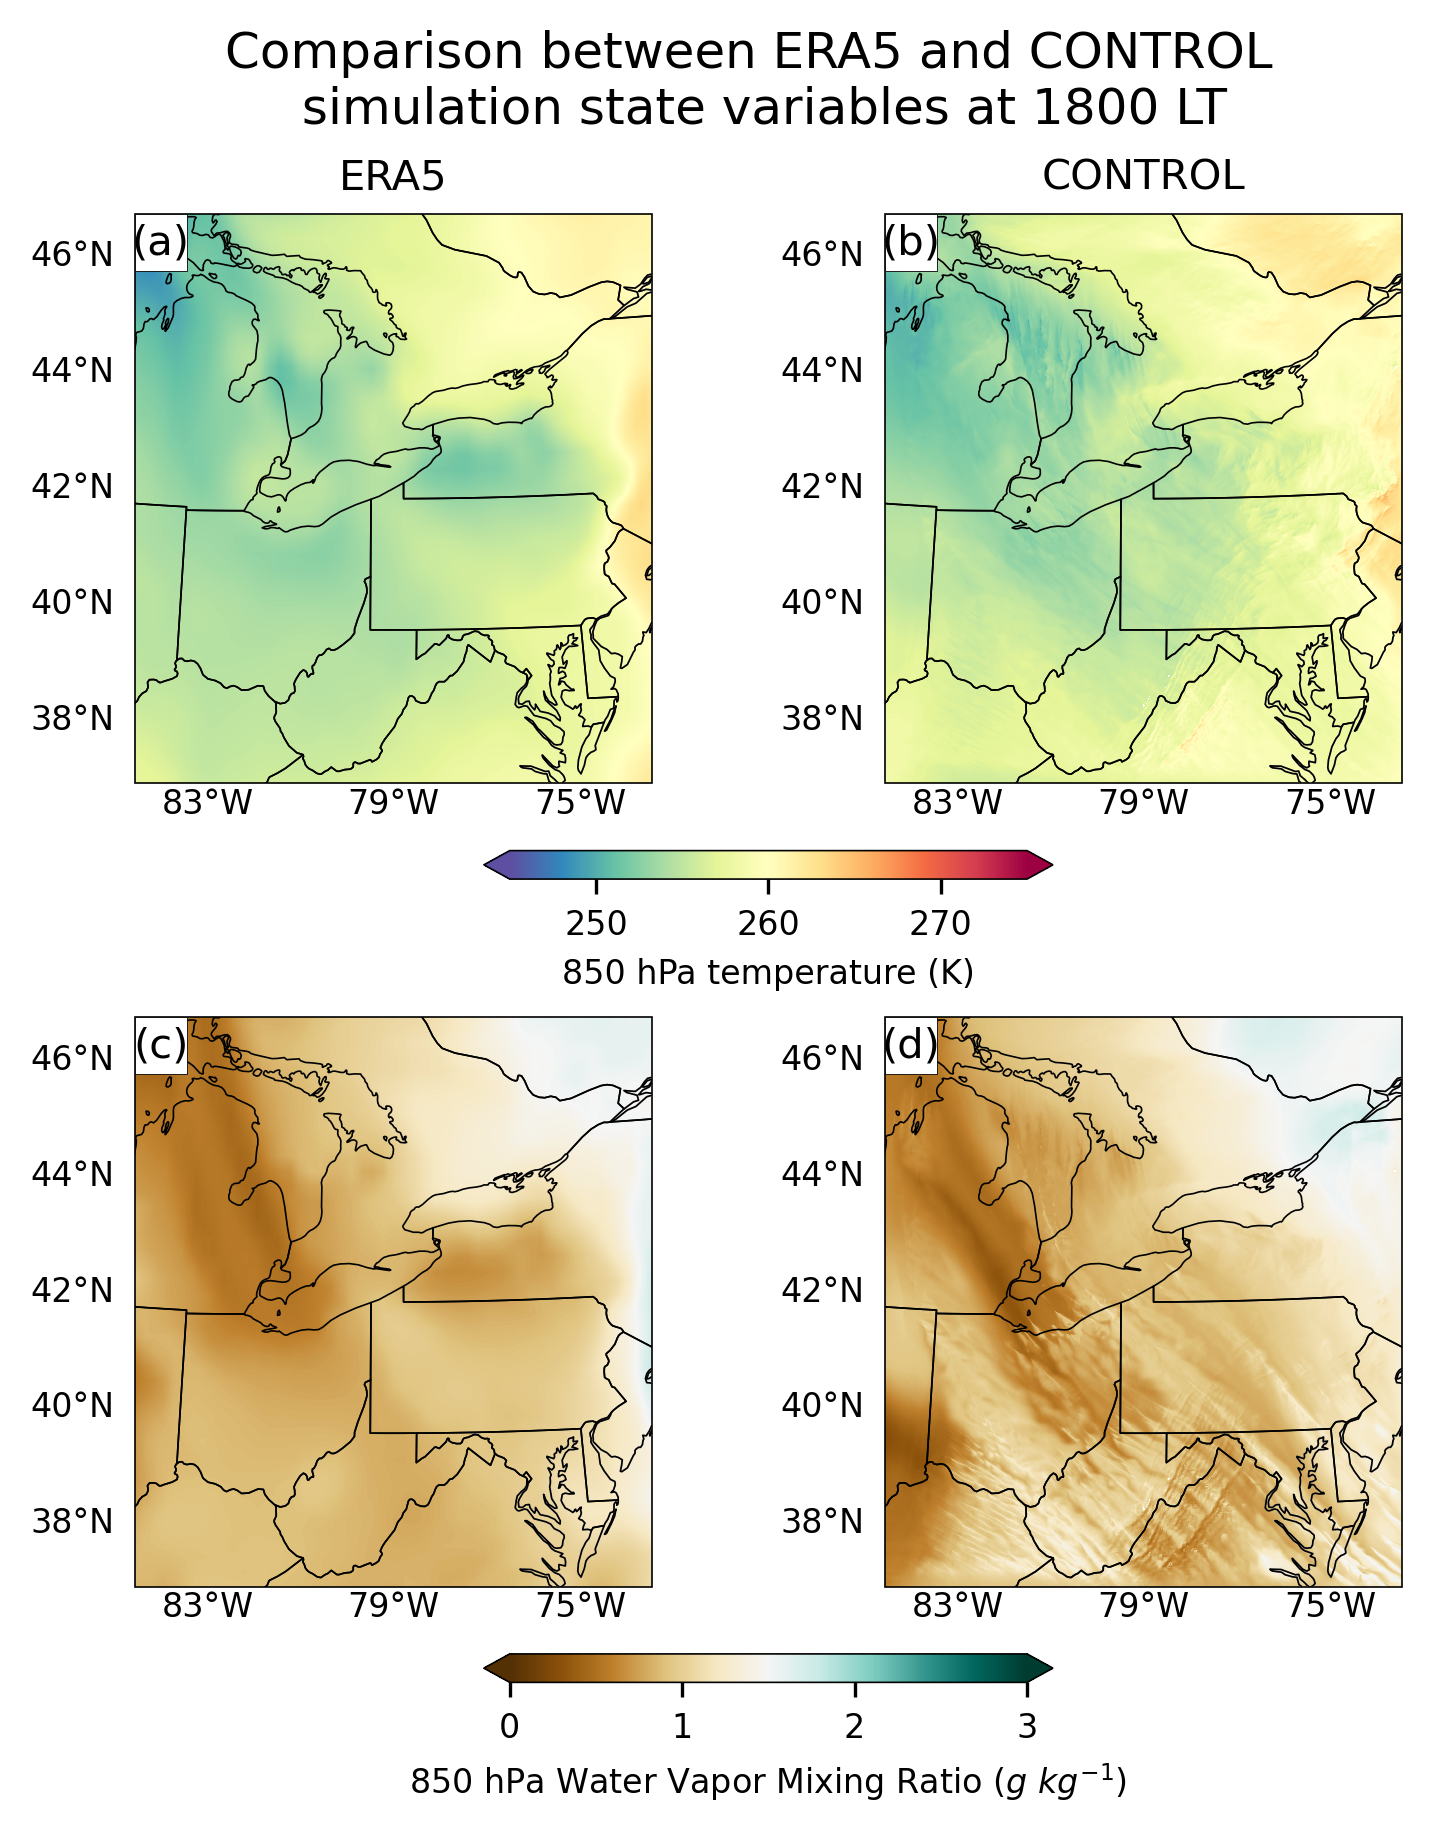

In [109]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (5, 6), subplot_kw = {"projection": ramscrs}, dpi = 300)
pltftime = "2010-01-02-230000"
plttimelocal = datetime.strptime(pltftime, "%Y-%m-%d-%H%M%S")-timedelta(hours = 5)
axlabels = ["(a)", "(b)", "(c)", "(d)"]
for i, ax in enumerate(fig.get_axes()):
    ax = add_cartofeatures_fulldomain(ax)
    left, width = 0, 0.10
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
tempmp = ax1.pcolormesh(controlgrid["x"], controlgrid["y"], eraramsgrid["t"].sel(time = plttimelocal, Pressure = 850), cmap = "Spectral_r", norm = MidpointNormalize(vmin = 245, vmax = 275, vcenter = 260), transform = ramscrs)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], presdata["t"].sel(Pressure = 850), cmap = "Spectral_r", norm = MidpointNormalize(vmin = 245, vmax = 275, vcenter = 260), transform = ramscrs)
tempcbar = fig.colorbar(tempmp, ax = [ax1, ax2], orientation = "horizontal", extend = "both", fraction = 0.05)
tempcbar.ax.tick_params(labelsize = 8)
tempcbar.set_label("850 hPa temperature (K)", fontsize = 8)
ax1.set_title("ERA5", fontsize = 10)
ax2.set_title("CONTROL", fontsize = 10)
vapmp = ax3.pcolormesh(controlgrid["x"], controlgrid["y"], 1000*eraramsgrid["q"].sel(time = plttimelocal, Pressure = 850), cmap = "BrBG", vmin = 0, vmax = 3, transform = ramscrs)
ax4.pcolormesh(controlgrid["x"], controlgrid["y"], 1000*presdata["q"].sel(Pressure = 850), cmap = "BrBG", vmin = 0, vmax = 3, transform = ramscrs)
vapcbar = fig.colorbar(vapmp, ax = [ax3, ax4], orientation = "horizontal", extend = "both", fraction = 0.05)
vapcbar.ax.tick_params(labelsize = 8)
vapcbar.set_label(r"850 hPa Water Vapor Mixing Ratio ($g \ kg^{-1}$)", fontsize = 8)
fig.suptitle("Comparison between ERA5 and CONTROL \n simulation state variables at 1800 LT", fontsize = 12)
fig.savefig(f"../PaperFigs/supplemental_eracomp_{ftime}.png")

In [ ]:
eraramsgrid.close(); del eraramsgrid
presdata.close(); del presdata